In [ ]:
#| default_exp t2s_up_wds
%load_ext autoreload
%autoreload 2

In [ ]:
#| exporti
import dataclasses
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import record_function

from huggingface_hub import hf_hub_download
from fastcore.basics import store_attr
from fastprogress import progress_bar

import webdataset as wds

In [ ]:
#| exporti
from pathlib import Path
import pylab as plt
import pandas as pd
import numpy as np

In [ ]:
#| exporti
import whisper
from whisperspeech.train import *
from whisperspeech.modules import *
from whisperspeech import vq_stoks

In [ ]:
from whisperspeech.wer_metrics import *
import torchaudio

In [ ]:
from fastprogress import master_bar

# Text to semantic tokens model

Multi-GPU training example:

    python3 -m whisperspeech.train_multi \
        --task "t2s_up_wds base --frozen_embeddings_model vqmodel-256c-dim64-4e-hyptuned-32gpu.model" \
        --input-dir "whisperspeech-t2s-512c-dim64/*.tar.gz 600000 --vq_codes=513"
        --batch-size 32 --epochs 1 \
        --tunables=--cps_input

# Dataset

In [ ]:
#| exporti
import re

class CharTokenizer:
    """Trivial tokenizer – just use UTF-8 bytes"""
    eot = 0
    
    def encode(self, txt):
        return list(bytes(txt.strip(), 'utf-8'))

    def decode(self, tokens):
        return bytes(tokens).decode('utf-8')
    
def tokenizer(ikey, okey, length):
    """Tokenizes a transcript"""
    tok = CharTokenizer()
    def _tokenizer(samples):
        for s in samples:
            toks = torch.tensor(tok.encode(s[ikey]))
            s[okey] = F.pad(toks, (0, length - toks.shape[-1]), value=tok.eot)
            yield s
    return _tokenizer

def ar_padder(ikey, okey, length, pad_token):
    """Pads the tokens for autoregresive training"""
    def _ar_padder(samples):
        for s in samples:
            toks = s[ikey]
            if isinstance(toks, (list, np.ndarray)): toks = torch.tensor(toks)
            toks = toks.to(torch.long)
            s['in_' +okey] = F.pad(toks, (1, length - toks.shape[-1] - 1), value=pad_token)
            s['out_'+okey] = F.pad(toks, (0, length - toks.shape[-1]), value=pad_token)
            yield s
    return _ar_padder

def char_per_seconder(txt_key, stoks_key, cps_key, stoks_per_second=25):
    """Adds the characters per second metric to the input data"""
    def _char_per_seconder(samples):
        for s in samples:
            secs = s[stoks_key].shape[-1] / stoks_per_second
            s[cps_key] = len(s[txt_key]) / secs
            yield s
    return _char_per_seconder

In [ ]:
#| exporti
def build_speaker_map(shards):
    speakers = set()
    for shard in shards:
        with open(shard+'.speakers.txt') as f: speakers = speakers.union(set(x.strip() for x in f.readlines()))
    return {id:i for i,id in enumerate(speakers)}

def speaker_id_extractor(speaker_map):
    def _extractor(samples):
        for s in samples:
            s['speaker'] = torch.tensor(speaker_map[s['__key__'].split("/")[1]])
            yield s
    return _extractor

In [ ]:
#| export
def load_datasets(
    input:str,             # webdataset folder or shard list
    samples:int,           # samples per epoch
    subsample:float=1,     # use a fraction of the files
    val_samples:int=512,
    vq_codes:int=4096,
):
    if isinstance(input, (Path, str)):
        path = Path(input)
        if path.is_dir():
            glob = '*-t2s-*.tar.gz'
        else:
            glob = path.name
            path = path.parent
        input = Path(path).glob(glob)
    elif isinstance(input, list):
        pass
    else:
        raise ArgumentError("input should be either a list of a path with an optional glob specifier")
    shards = [str(x) for x in input]

    speaker_map = build_speaker_map(shards)
    
    def ds(shards, length):
        ds = wds.WebDataset(wds.ResampledShards(shards)).compose(
            wds.decode(),
            speaker_id_extractor(speaker_map),
            wds.select(lambda s: s['stoks.npy'].shape[-1] > 12), # select samples > .5s
            tokenizer('txt', 'ttoks', length=550),
            ar_padder('stoks.npy', 'stoks', length=750, pad_token=vq_codes-1),
            char_per_seconder('txt', 'stoks.npy', 'cps', stoks_per_second=25),
            wds.to_tuple('ttoks', 'speaker', 'cps', 'in_stoks', 'out_stoks'),
            wds.batched(64)
        )
        ds.speakers = speaker_map
        ds.total_samples = length
        ds.stoks_len = 750
        ds.stoks_codes = vq_codes
        ds.ttoks_len = 550
        return ds.compose(wds.slice(length // 64)).with_epoch(length // 64).with_length(length // 64)
    
    return (
        ds(shards[1:], samples),
        ds(shards[:1], val_samples),
    )

In [ ]:
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)

In [ ]:
for s in val_ds: break
s

[tensor([[ 65,  32, 102,  ...,   0,   0,   0],
         [109, 101, 110,  ...,   0,   0,   0],
         [ 89, 101, 116,  ...,   0,   0,   0],
         ...,
         [ 66, 117, 116,  ...,   0,   0,   0],
         [ 66, 117, 116,  ...,   0,   0,   0],
         [ 70, 114, 111,  ...,   0,   0,   0]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([14.75      , 12.22044728, 15.20618557, 14.76470588, 15.        ,
        14.85943775, 14.4       , 16.25      , 13.85714286, 17.17687075,
        16.36500754, 15.2       , 12.77372263, 13.84026258, 15.85      ,
        11.39705882, 16.33333333, 15.68877551, 13.64705882, 16.13729508,
        13.7245841 , 15.27272727, 14.46078431, 16.35294118, 17.15976331,
        15.09090909, 12.0625    , 14.52483801, 13.62645349, 13.20033956,
        14.23076923, 14.39130435, 14.851851

# Modeling

In [ ]:
#| export
def rand(start, end):
    return random.random() * (end - start) + start

@dataclasses.dataclass
class Tunables:
    init_std :float = 1
    embeddings_std :float = .01
    embeddings_lr_scale: float = 5
    embedding_projector_lr_scale: float = 2.5
    output_mult :float = .35
    query_mult :float = 1
    encoder_depth_ratio :float = 0.25
    eot_dropout_p :float = .5
    cps_input: bool = True
    cps_bins: int = 32
        
    lr0 :float = 1.5e-3
    clip_gradient_norm :float = .2
    weight_decay :float = 1e-1
    warmup_steps :float = 4000

    random :bool = False

    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
            self.init_std = 10**rand(-1,1)
            self.embeddings_std = 10**rand(-3,-.7)
            self.embeddings_lr_scale = rand(2,6)
            self.output_mult = rand(0.25,0.65)
            self.query_mult = 2**rand(-2,3)
            self.encoder_depth_ratio = 0.25
            
            self.lr0 = rand(1,5)*1e-3
            self.clip_gradient_norm = 10**rand(-3,0)
            self.warmup_steps = 100*(10**rand(1,1.85))

In [ ]:
#| exporti
class EmbeddingProjector(nn.Linear):
    pass

In [ ]:
#| export
class Encoder(nn.Module):
    def __init__(self, depth=6, width=384, n_head=6, length=1500, codes=1024, emb_width=384, ffn_mult=4, pos_embs=None, tunables=Tunables()):
        super().__init__()
        self.emb_width = emb_width
        
        self.emb_factor = width != emb_width
    
        self.embedding = nn.Embedding(codes, emb_width)
        if self.emb_factor:
            self.emb_to_hidden = EmbeddingProjector(emb_width, width)

        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)

        self.layers = nn.Sequential(*[
            ResidualAttentionBlock(width, n_head,
                                   qk_scale=tunables.query_mult*8/math.sqrt(width/n_head), ffn_mult=ffn_mult) for _ in range(depth)
        ])

        self.ln_post = LayerNorm(width)
        
    def forward(self, Stoks):
        xin = self.embedding(Stoks)
        if self.emb_factor:
            xin = self.emb_to_hidden(xin)
        
        assert xin.shape[1:] == self.positional_embedding.shape, "incorrect semantic token shape"
        xin = (xin + self.positional_embedding).to(xin.dtype)

        return self.ln_post(self.layers(xin))

In [ ]:
#| export
class Decoder(nn.Module):
    def __init__(self, depth=6, stoks_width=384, width=384, n_head=6, length=1500, codes=1024, ffn_mult=4, pos_embs=None, tunables=Tunables()):
        super().__init__()
        self.length = length
        self.codes = codes
        self.width = width
        self.stoks_width = stoks_width
        
        self.emb_factor = width != stoks_width
    
        # embed semantic tokens
        self.embedding = nn.Embedding(codes, stoks_width)
        if self.emb_factor:
            self.emb_to_hidden = EmbeddingProjector(stoks_width, width)
            self.hidden_to_emb = EmbeddingProjector(width, stoks_width)

        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)
        
        self.layers = nn.ModuleList([
            ResidualAttentionBlock(width, n_head, cross_attention=True,
                                   qk_scale=tunables.query_mult*8/math.sqrt(width/n_head), ffn_mult=ffn_mult) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
        
    def forward(self, Stoks, xenc, cps=None):
        Sembs = self.embedding(Stoks)
            
        if self.emb_factor:
            Sembs = self.emb_to_hidden(Sembs)
    
        xin = (Sembs + self.positional_embedding[:Sembs.shape[1]]).to(xenc.dtype)
        if cps is not None: xin = xin + cps
    
        x = xin
        for l in self.layers: x = l(x, xenc, causal=True)
        
        x = self.ln_post(x)
    
        if self.emb_factor:
            x = self.hidden_to_emb(x)
        
        logits = (x @ self.embedding.weight.to(x.dtype).T).float()
        return logits

In [ ]:
#| export
class TSARTransformer(nn.Module):
    def __init__(self, depth=6, n_head=6, head_width=64, ffn_mult=4, language='en',
                 ttoks_len=200, ttoks_codes=50364, ttoks_width=None,
                 stoks_len=1500, stoks_codes=1024, stoks_width=None,
                 tunables=Tunables()):
        assert language == 'en', "only english is supported right now"
        super().__init__()
        store_attr("depth,n_head,head_width,ffn_mult,stoks_width,ttoks_width,ttoks_len,stoks_len,ttoks_codes,stoks_codes,language")

        width = n_head * head_width
        self.width = width
        self.base_width = 3 * head_width
        self.tunables = tunables
        if self.stoks_width is None: self.stoks_width = self.width
        if self.ttoks_width is None: self.ttoks_width = self.width
        
        if tunables.cps_input:
            self.cps_embeddings = nn.Embedding(tunables.cps_bins, self.width)
        else:
            self.cps_embeddings = None
        
        encoder_depth = int(depth * 2 * tunables.encoder_depth_ratio)
        decoder_depth = depth * 2 - encoder_depth
        tformer_args = dict(width=width, n_head=n_head, ffn_mult=ffn_mult, tunables=tunables)
        self.encoder = Encoder(length=ttoks_len, codes=ttoks_codes, emb_width=self.ttoks_width, depth=encoder_depth, **tformer_args)
        self.decoder = Decoder(length=stoks_len, codes=stoks_codes, stoks_width=self.stoks_width, depth=decoder_depth, **tformer_args)
        
        self.tokenizer = None
        
        self.apply(self.init_transformer)

    def load_frozen_semantic_embeddings(self, vqmodel):
        with torch.no_grad():
            self.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
            self.decoder.embedding.lr_scale = 0

    def setup(self, device):
        pass

    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, EmbeddingProjector):
            m.lr_scale = self.tunables.embedding_projector_lr_scale
            std = self.tunables.init_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)
            
    def forward(self, Ttoks, speakers, cpss, in_stoks, out_stoks=None, loss=True):
        with record_function("encoder"):
            xenc = self.encoder(Ttoks.to(torch.long))
        with record_function("decoder"):
            if self.cps_embeddings:
                cps_bin = (cpss / 20 * self.tunables.cps_bins).to(torch.long)
                cps_bin[cps_bin >= self.tunables.cps_bins] = self.tunables.cps_bins-1
                cps_embs = self.cps_embeddings(cps_bin).unsqueeze(1)
            else:
                cps_embs = None
            logits = self.decoder(in_stoks, xenc, cps=cps_embs) * self.tunables.output_mult / (self.width / self.base_width)
        if loss is not None:
            with record_function("loss"):
                loss = F.cross_entropy(logits.transpose(-1,-2), out_stoks)#, reduction='none')
        return logits, loss

    #
    # inference
    #
    @classmethod
    def load_model(cls, repo_id="collabora/whisperspeech", filename="t2s_up_wds.model", local_filename=None):
        if not local_filename:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        spec = torch.load(local_filename)
        model = cls(**spec['config'], tunables=Tunables(**spec['tunables']))
        model.load_state_dict(spec['state_dict'])
        model.eval()
        return model

    def load_checkpoint(self, local_filename):
        spec = torch.load(local_filename, map_location='cpu')
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self

    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict()), fname)

    def ensure_tokenizer(self):
        assert not self.training
        if self.tokenizer is None: self.tokenizer = CharTokenizer()
        #whisper.tokenizer.get_tokenizer(multilingual=True)  

    @property
    def device(self):
        return next(self.parameters()).device
    
    @torch.no_grad()
    def generate(self, txt, cps=15, N=None, T=0.7, top_k=None, show_progress_bar=True):
        self.ensure_tokenizer()
        N = N or self.stoks_len
        dev = self.device
        ttoks = torch.tensor(self.tokenizer.encode(txt), device=dev)
        ttoks = F.pad(ttoks, (0, self.ttoks_len - len(ttoks)), value=self.tokenizer.eot).unsqueeze(0)
        cpss = torch.tensor([cps], device=dev)
        toks = torch.zeros((1,N), dtype=torch.long, device=dev)
        toks[0,0] = self.stoks_codes-1
        it = range(1,N)
        if show_progress_bar: it = progress_bar(it)
        for i in it:
            p, _ = self(ttoks, None, cpss, toks[:,:i], loss=None)
            last_p = p[0,-1]
            if top_k:
                last_p[last_p < torch.topk(last_p, top_k).values[-1,None]] = -torch.inf
            tok = torch.multinomial((last_p / float(T)).softmax(-1), 1)
            toks[0,i] = tok
            if toks[0,i] == self.stoks_codes-1: return toks[0,1:i]
        return toks[0,1:]
    
    @torch.no_grad()
    def generate_batch(self, txts, N=None, T=1.1, top_k=7, show_progress_bar=True):
        self.ensure_tokenizer()
        N = self.stoks_len
        dev = self.device
        ttoks = []
        for txt in txts:
            ttoks_ = torch.tensor(self.tokenizer.encode(txt), device=dev)
            ttoks_ = F.pad(ttoks_, (0, self.ttoks_len - len(ttoks_)), value=self.tokenizer.eot).unsqueeze(0)
            ttoks.append(ttoks_)
        ttoks = torch.cat(ttoks, dim=0)
        toks = torch.zeros((len(ttoks),N), dtype=torch.long, device=dev)
        it = range(N)
        if show_progress_bar: it = progress_bar(it)
        for i in it:
            p, _ = self(ttoks, toks[:,:i], loss=None)
            last_p = p[:,-1]
            if top_k:
                last_p[last_p < torch.topk(last_p, top_k).values[:,-1,None]] = -torch.inf
            tok = torch.multinomial((last_p / float(T)).softmax(-1), 1)
            toks[:,i] = tok[:,0]
            if (toks[:,i] == self.stoks_codes-1).all(): return toks[:,:i]
        return toks

In [ ]:
#| export
def _make_model(size:str, tunables:Tunables=Tunables(), dataset=None, **kwargs):
    kwargs = dict(stoks_len = dataset.stoks_len, ttoks_len = dataset.ttoks_len, tunables=tunables, **kwargs)
    if 'stoks_codes' not in kwargs: kwargs['stoks_codes'] = dataset.stoks_codes
    if size == 'micro':
        return TSARTransformer(depth=2, n_head=3, ffn_mult=1, **kwargs)
    if size == 'tiny':
        return TSARTransformer(depth=4, n_head=6, **kwargs)
    if size == 'base':
        return TSARTransformer(depth=6, n_head=8, **kwargs)
    if size == 'small':
        return TSARTransformer(depth=12, n_head=16, **kwargs)

def make_model(size:str, frozen_embeddings_model:str=None, tunables:Tunables=Tunables(), dataset:torch.utils.data.Dataset=None):
    if frozen_embeddings_model:
        vqmodel = vq_stoks.RQBottleneckTransformer.load_model(frozen_embeddings_model)
        model = _make_model(size, tunables, dataset, stoks_codes=vqmodel.vq_codes+1, stoks_width=vqmodel.rq.layers[0]._codebook.embed[0].shape[-1])
        model.load_frozen_semantic_embeddings(vqmodel)
    else:
        model = _make_model(size, quantizers, tunables, dataset)
    return model

samples,train,val,time
50048,2.32671,2.54252,00:49
100032,1.80803,1.89586,01:37
150016,1.54782,1.59268,02:26
200000,1.35583,1.46361,03:13
250048,1.41018,1.41785,04:02
267776,1.34585,1.41379,04:19


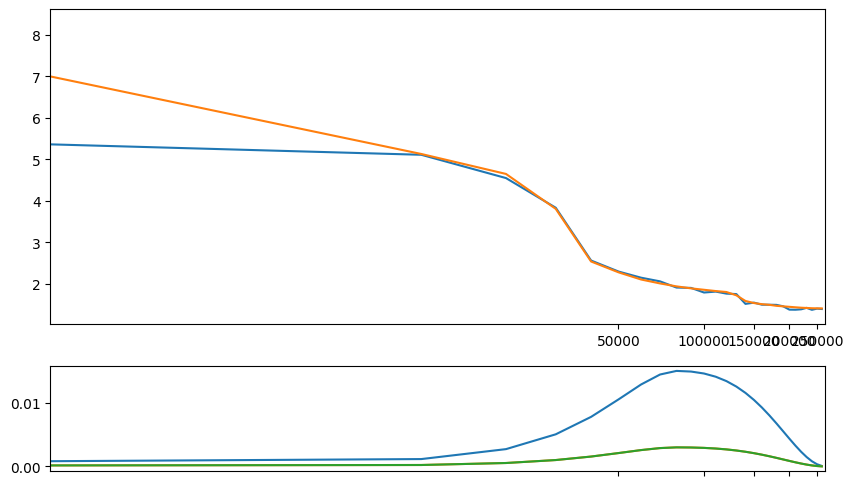

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
model = make_model('micro', dataset=train_ds, ttoks_codes=256, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,3.30265,3.83503,00:48
100032,2.02446,2.18862,01:35
150016,2.05050,2.01388,02:22
200000,1.93012,1.95299,03:09
250048,1.94291,1.92251,03:57
267776,1.89118,1.91820,04:14


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__><function _MultiProcessingDataLoaderIter.__del__>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'asser

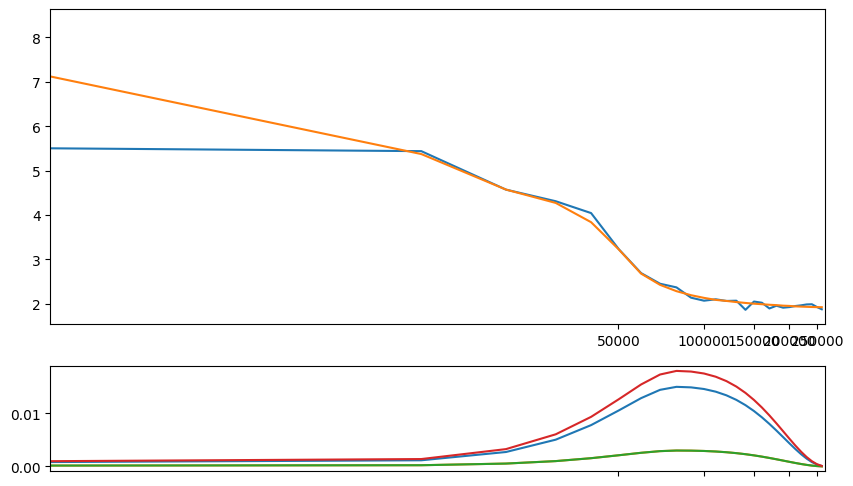

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
model = make_model('micro', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.89901,3.55692,00:48
100032,1.98145,2.05116,01:36
150016,1.68419,1.85444,02:23
200000,1.62686,1.66584,03:12
250048,1.55128,1.56165,04:00
267776,1.53336,1.55427,04:17


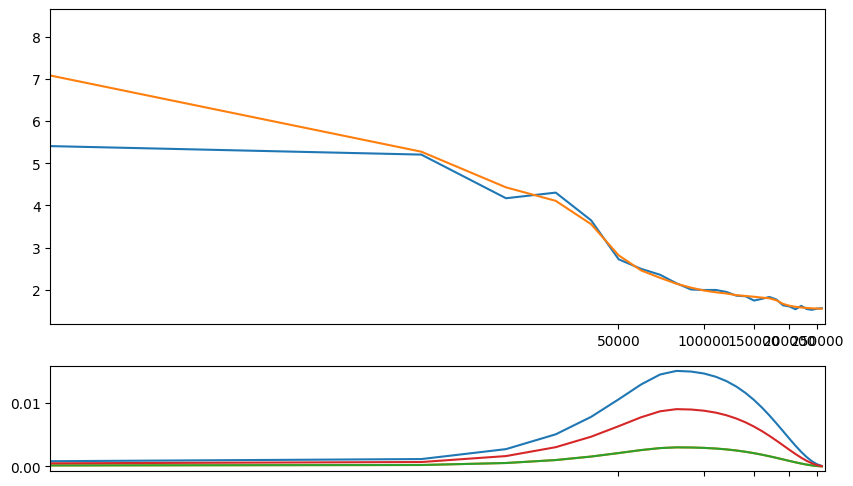

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
model = make_model('micro', dataset=train_ds, ttoks_codes=256, stoks_width=64, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.71431,3.25542,00:48
100032,1.96834,1.97702,01:37
150016,1.67089,1.73445,02:25
200000,1.48925,1.51701,03:12
250048,1.35983,1.45833,04:02
267776,1.35444,1.45313,04:19


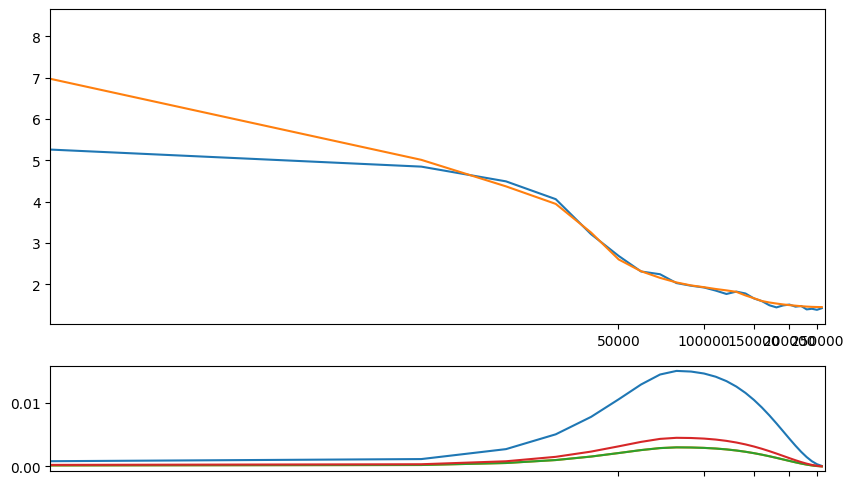

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
model = make_model('micro', dataset=train_ds, ttoks_codes=256, stoks_width=128, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.58822,2.71430,00:48
100032,2.22865,2.29081,01:36
150016,2.24062,2.16505,02:24
200000,2.15208,2.10129,03:12
250048,2.11630,2.06462,04:01
267776,2.05746,2.05924,04:18


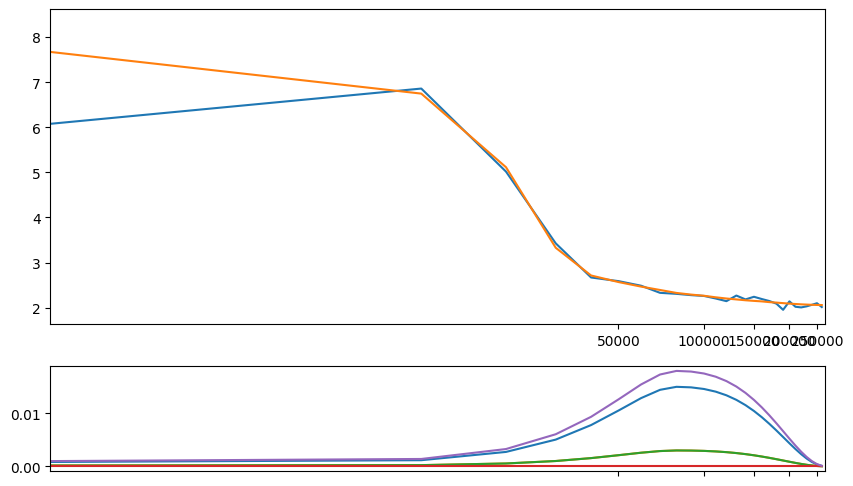

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-4e-hyptuned-32gpu.model').cuda()
model = make_model('micro', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.40318,2.89732,01:57
100032,1.82548,1.89599,03:53
150016,1.38077,1.49867,05:49
200000,1.27140,1.38744,07:46
250048,1.18064,1.32460,09:43
300032,1.18833,1.30813,11:39
350016,1.15768,1.30107,13:36
400000,1.04729,1.32198,15:32
450048,1.01181,1.32959,17:28
500032,1.07383,1.33221,19:25


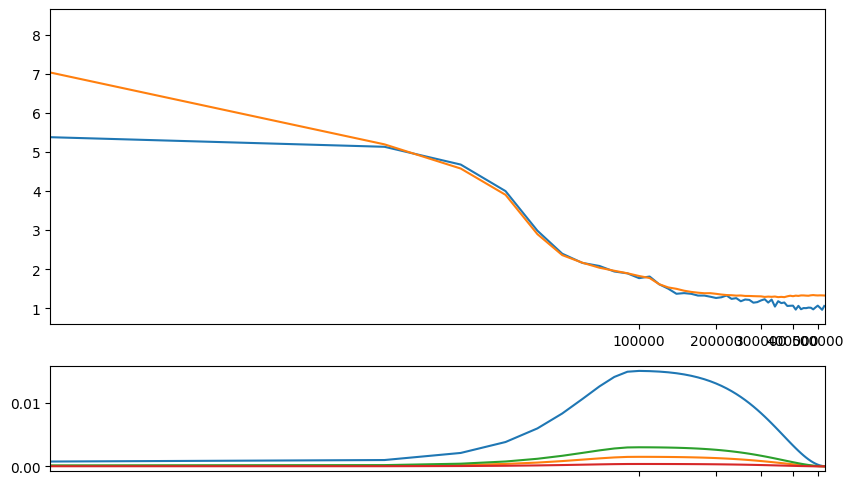

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,3.75509,4.11667,01:54
100032,2.25885,2.30041,03:48
150016,1.91093,1.95126,05:42
200000,1.84764,1.86652,07:36
250048,1.77182,1.81652,09:31
300032,1.79985,1.78369,11:25
350016,1.68099,1.75393,13:19
400000,1.66937,1.71709,15:14
450048,1.60969,1.69115,17:08
500032,1.52963,1.67443,19:02


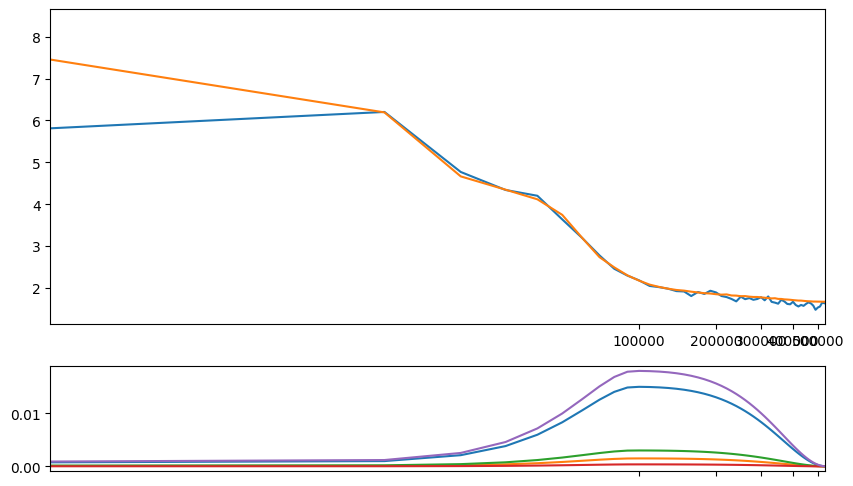

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.66129,3.17833,01:55
100032,2.20422,2.25224,03:50
150016,1.81939,2.03050,05:46
200000,1.89059,1.94665,07:41
250048,1.80682,1.90035,09:36
300032,1.76392,1.87051,11:32
350016,1.74465,1.85350,13:27
400000,1.67498,1.84700,15:22
450048,1.75115,1.83276,17:18
500032,1.59461,1.82666,19:13


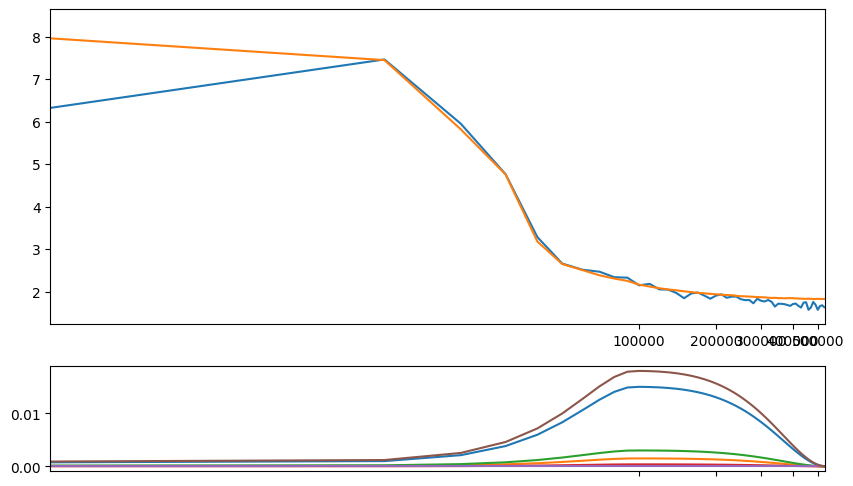

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-4e-hyptuned-32gpu.model').cuda()
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.56502,2.57105,01:55
100032,2.09122,2.19948,03:50
150016,1.52316,1.76259,05:47
200000,1.46774,1.54980,07:42
250048,1.32339,1.45032,09:37
300032,1.33820,1.40221,11:33
350016,1.24444,1.37554,13:28
400000,1.20127,1.35640,15:23
450048,1.17260,1.36000,17:19
500032,1.12745,1.35252,19:14


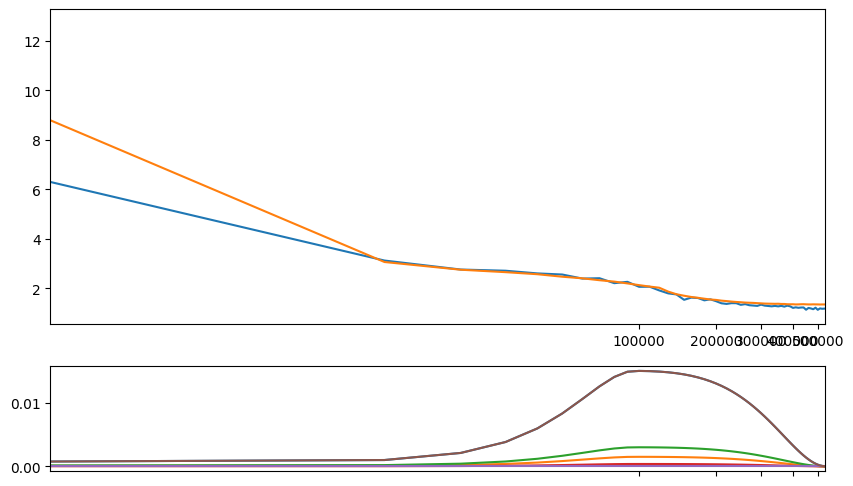

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-4e-hyptuned-32gpu.model').cuda()
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.55643,2.57862,01:56
100032,2.07709,2.21662,03:51
150016,1.73660,1.76801,05:48
200000,1.47864,1.51147,07:43
250048,1.33383,1.42171,09:38
300032,1.30044,1.38115,11:34
350016,1.23273,1.36965,13:29
400000,1.23627,1.35942,15:24
450048,1.18555,1.33863,17:20
500032,1.12210,1.35270,19:15


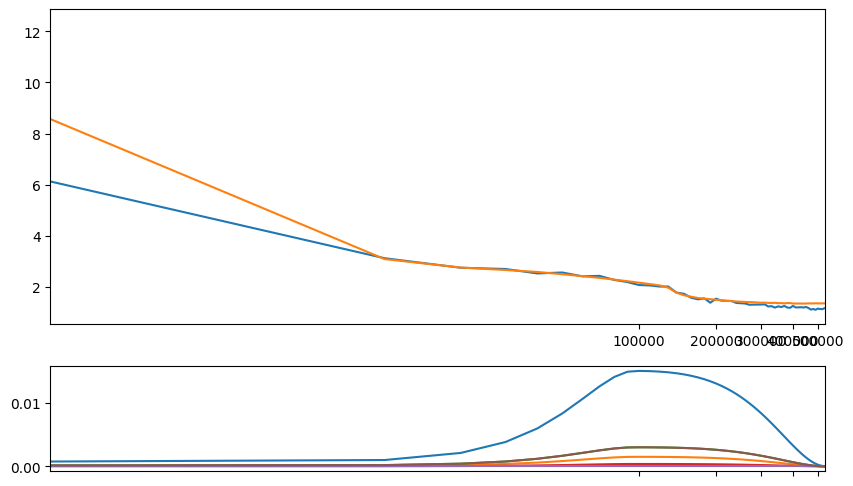

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-4e-hyptuned-32gpu.model').cuda()
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=1)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.47366,2.56469,01:56
100032,2.07719,2.18855,03:51
150016,1.62540,1.72760,05:46
200000,1.45468,1.51390,07:42
250048,1.39196,1.43748,09:47
300032,1.29714,1.39951,12:06
350016,1.27493,1.36245,14:24
400000,1.24066,1.35400,16:42
450048,1.16084,1.34805,18:47
500032,1.17269,1.34920,20:42


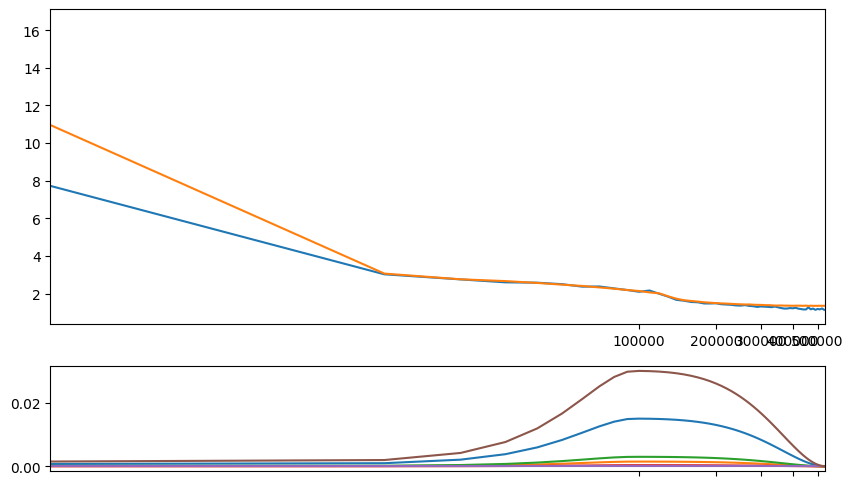

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-4e-hyptuned-32gpu.model').cuda()
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=10)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

## Codebook dim and VQ codes

samples,train,val,time
50048,2.56502,2.57105,01:55
100032,2.09122,2.19948,03:50
150016,1.52316,1.76259,05:47
200000,1.46774,1.54980,07:42
250048,1.32339,1.45032,09:37
300032,1.33820,1.40221,11:33
350016,1.24444,1.37554,13:28
400000,1.20127,1.35640,15:23
450048,1.17260,1.36000,17:19
500032,1.12745,1.35252,19:14


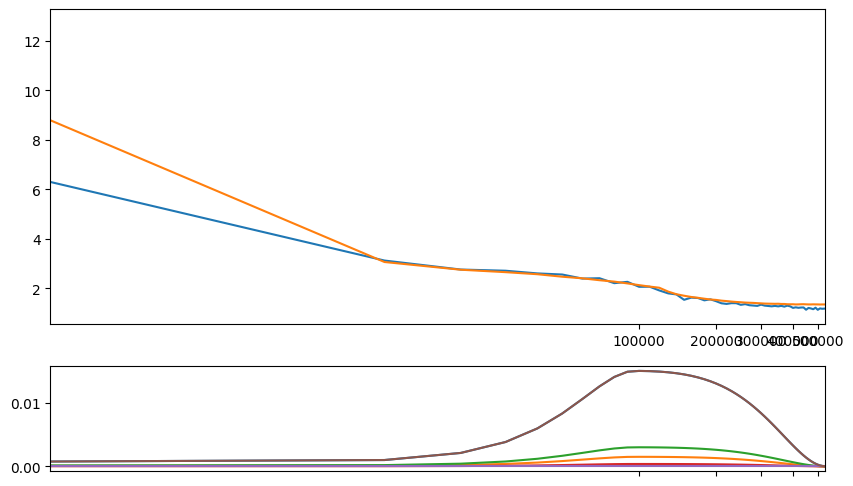

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('t2s-6454/*.tar.gz', 67000)
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-4e-hyptuned-32gpu.model').cuda()
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

In [ ]:
vqmodel.vq_codes

512

In [ ]:
for x in val_ds: break
x

[tensor([[ 84, 104, 101,  ...,   0,   0,   0],
         [116, 104, 114,  ...,   0,   0,   0],
         [ 84, 104, 101,  ...,   0,   0,   0],
         ...,
         [ 77, 121,  32,  ...,   0,   0,   0],
         [ 70, 111, 108,  ...,   0,   0,   0],
         [ 85, 110, 100,  ...,   0,   0,   0]]),
 tensor([[513, 273, 195,  ..., 513, 513, 513],
         [513, 303,  89,  ..., 513, 513, 513],
         [513,  46, 462,  ..., 513, 513, 513],
         ...,
         [513, 454, 173,  ..., 513, 513, 513],
         [513, 454, 273,  ..., 513, 513, 513],
         [513, 332, 332,  ..., 513, 513, 513]]),
 tensor([[273, 195, 100,  ..., 513, 513, 513],
         [303,  89, 351,  ..., 513, 513, 513],
         [ 46, 462, 453,  ..., 513, 513, 513],
         ...,
         [454, 173, 173,  ..., 513, 513, 513],
         [454, 273, 198,  ..., 513, 513, 513],
         [332, 332,  88,  ..., 513, 513, 513]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0

samples,train,val,time
50048,1.82633,2.22741,01:32
100032,1.60664,1.93017,03:05
150016,1.31743,1.83070,04:37
200000,1.47108,1.79051,06:10
250048,1.34203,1.68920,07:42
300032,1.35330,1.65576,09:15
350016,1.36777,1.62137,10:48
400000,1.28777,1.59741,12:20
450048,1.21631,1.57967,13:53
500032,1.20893,1.57008,15:26


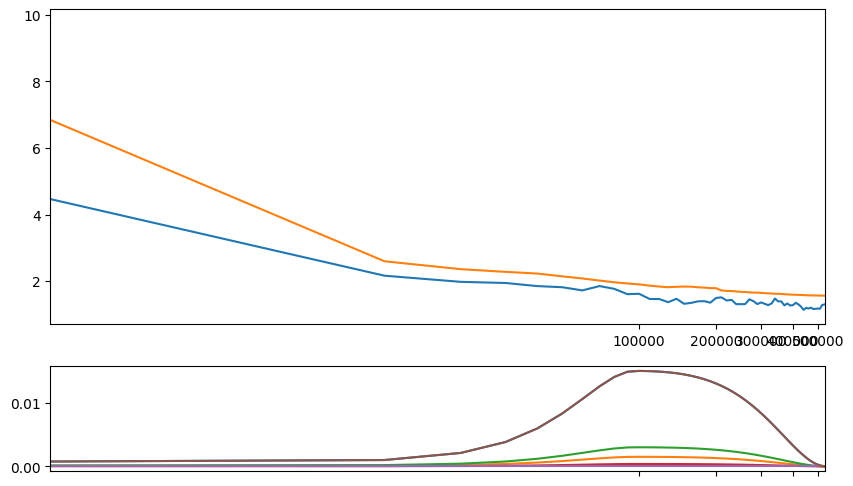

In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c/*.tar.gz', 67000, vq_codes=vqmodel.vq_codes+1)
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

In [ ]:
vqmodel.vq_codes

512

samples,train,val,time
50048,1.47909,1.92589,01:33
100032,1.27453,1.60590,03:06
150016,1.21110,1.39237,04:39
200000,0.94160,1.33038,06:12
250048,1.01031,1.22544,07:46
300032,0.94135,1.15930,09:19
350016,0.81337,1.04483,10:53
400000,0.75797,0.99746,12:26
450048,0.74541,0.96900,13:59
500032,0.78007,0.94995,15:32


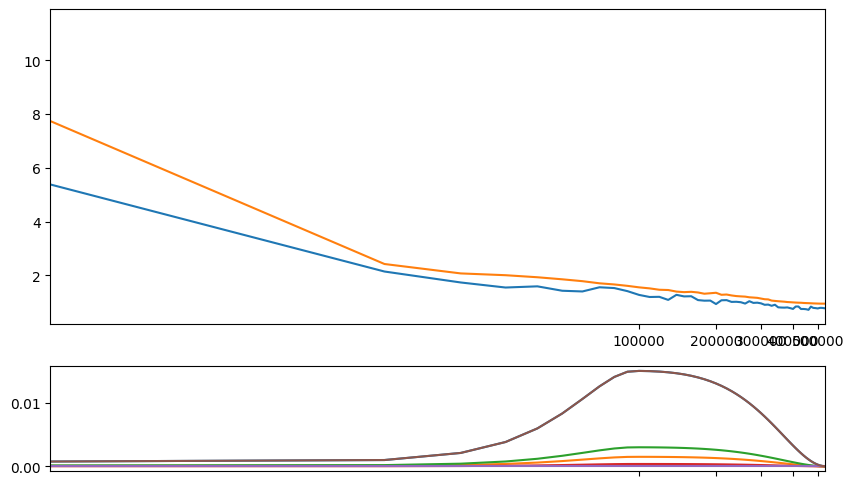

In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*.tar.gz', 67000, vq_codes=vqmodel.vq_codes+1)
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
model.save_model('t2s-chr-tiny-base.en-2d-512c-dim64-6454.model')

samples,train,val,time
50048,1.54400,1.56100,03:07
100032,1.39910,1.37488,06:15
150016,1.39666,1.29138,09:22
200000,1.25551,1.25673,12:30
250048,1.32616,1.23933,15:37
300032,1.26494,1.21040,18:45
350016,1.24198,1.19714,21:52
400000,1.20484,1.18515,25:00
450048,1.23590,1.16427,28:08
500032,1.16193,1.13852,31:15


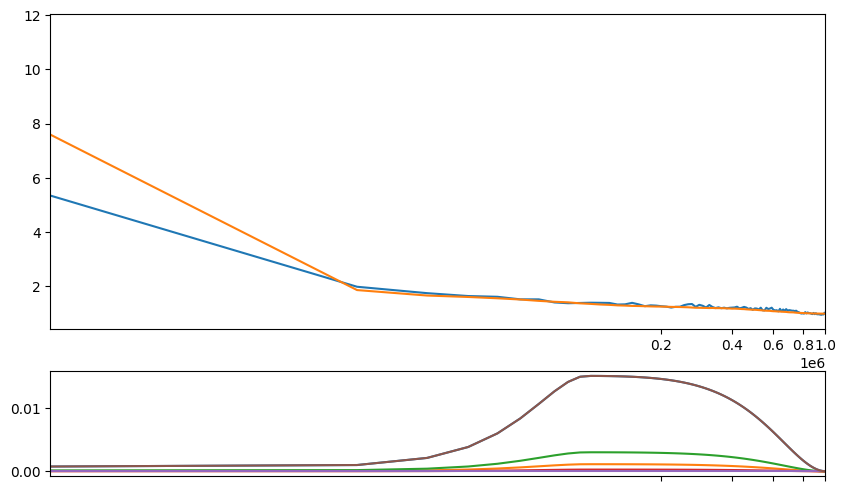

In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
model.save_model('t2s-chr-base-base.en-2d-512c-dim64-6454.model')

samples,train,val,time
50048,1.75974,2.00099,00:25
100032,1.28389,1.75231,00:51
150016,1.26908,1.60221,01:17
200000,0.95525,1.16684,01:43
250048,0.96412,1.08697,02:10
300032,0.83162,1.04516,02:35
350016,0.79592,1.03185,03:01
400000,0.84238,0.99971,03:27
450048,0.87118,0.98406,03:53
500032,0.86152,0.96493,04:19


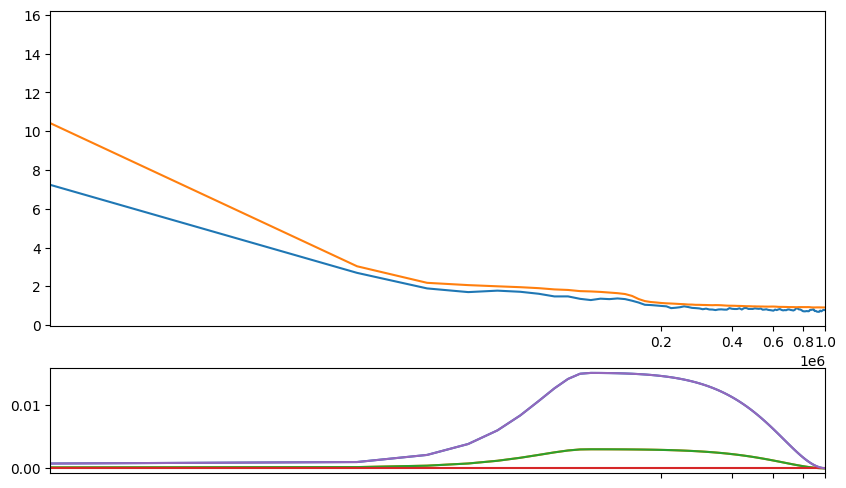

In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*-6454-*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('micro', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=False)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-base-base.en-2d-512c-dim64-6454.model')

samples,train,val,time
50048,1.66787,2.02706,00:26
100032,1.40207,1.76437,00:51
150016,1.27476,1.62537,01:17
200000,1.04374,1.26855,01:43
250048,0.98632,1.15448,02:10
300032,0.86521,1.10903,02:35
350016,0.85357,1.09162,03:02
400000,0.87830,1.06209,03:28
450048,0.85805,1.04703,03:54
500032,0.89811,1.02455,04:21


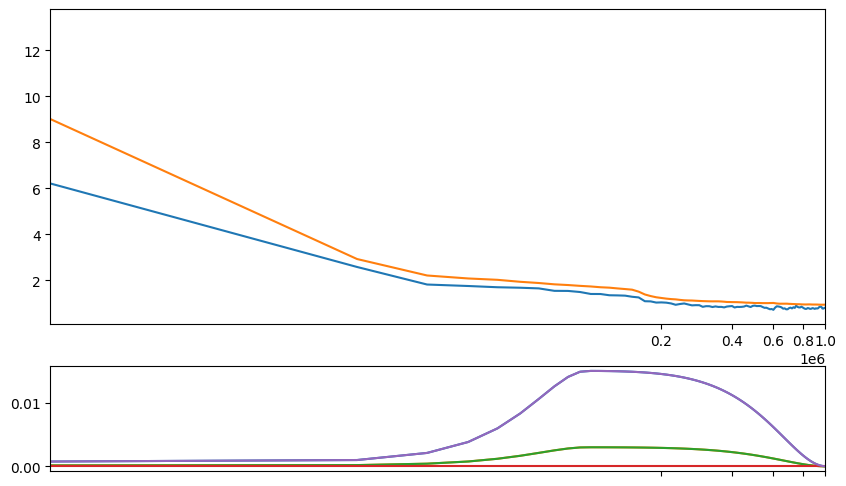

In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*-6454-*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('micro', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

samples,train,val,time
50048,1.66341,2.03399,00:26
100032,1.39218,1.79365,00:52
150016,1.25304,1.62505,01:18
200000,1.01684,1.18102,01:44
250048,0.92334,1.09278,02:11
300032,0.87596,1.06255,02:36
350016,0.79978,1.04593,03:03
400000,0.83765,1.01986,03:29
450048,0.86234,1.00090,03:55
500032,0.83526,0.98805,04:21


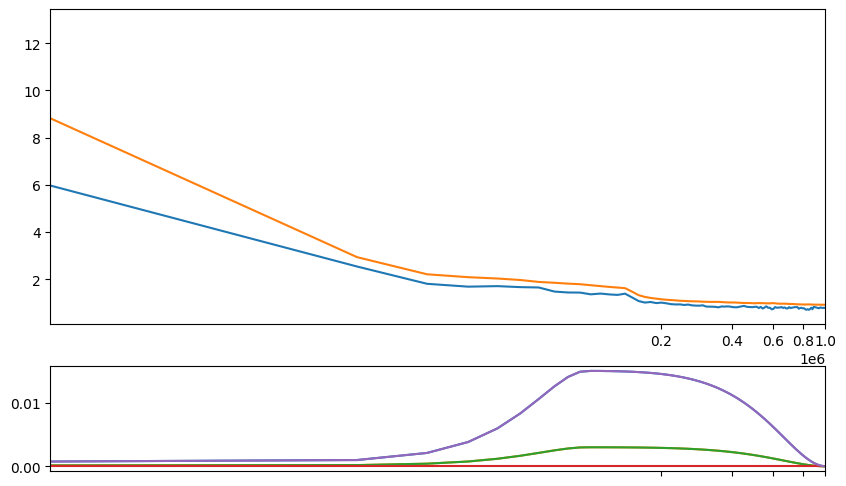

In [ ]:
# cps += in decoder
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*-6454-*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('micro', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

samples,train,val,time
50048,1.53023,1.95611,03:08
100032,1.29101,1.72470,06:16
150016,1.27883,1.58126,09:24
200000,1.04288,1.43338,12:32
250048,0.85578,1.04747,15:40
300032,0.78075,0.93366,18:49
350016,0.70612,0.89653,21:57
400000,0.67291,0.86028,25:04
450048,0.74054,0.83844,28:12
500032,0.72978,0.82141,31:21


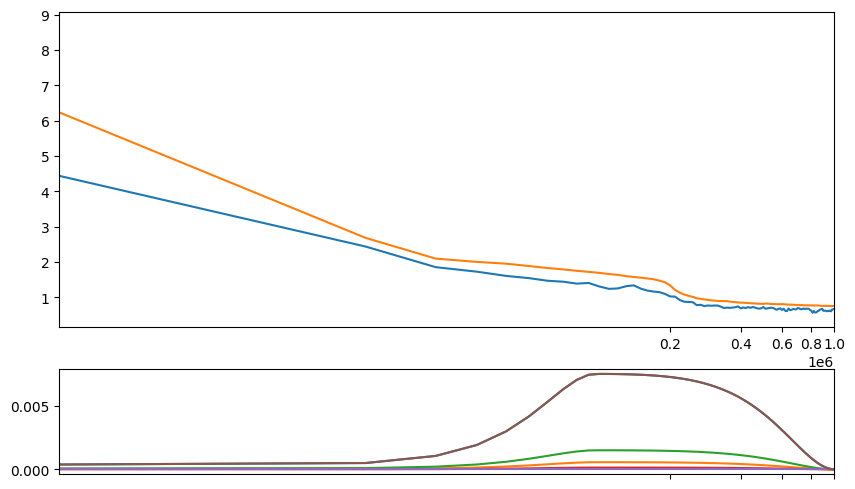

In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*-6454-*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0/2, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
model.save_model('t2s-chr-base-base.en-2d-512c-dim64-cps-6454.model')

samples,train,val,time
50048,1.64473,2.00029,03:08
100032,1.39717,1.78492,06:16
150016,1.34219,1.63625,09:24
200000,1.24191,1.48726,12:32
250048,1.14523,1.36233,15:40
300032,1.04355,1.24797,18:48
350016,0.86282,1.20460,21:56
400000,0.92359,1.12239,25:04
450048,0.89628,1.07208,28:13
500032,0.86888,1.01718,31:21


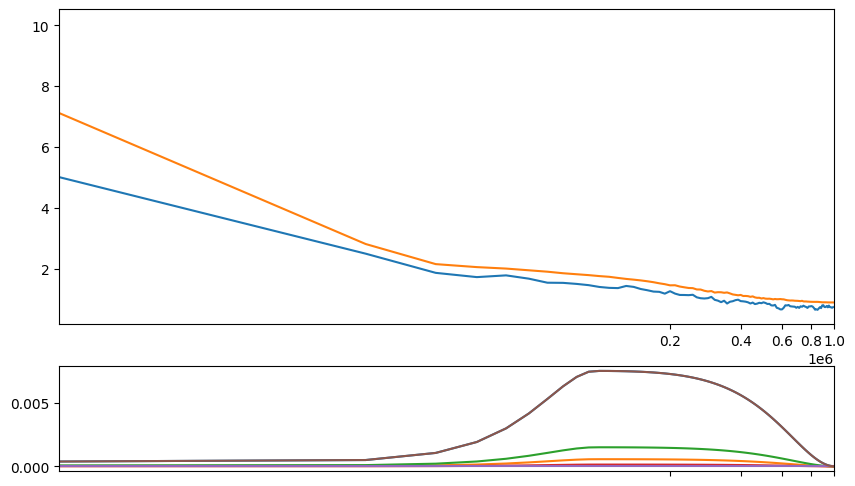

In [ ]:
# make sure it works at all, deocder cps
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*-6454-*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0/2, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
model.save_model('t2s-chr-base-base.en-2d-512c-dim64-deccps-6454.model')

In [ ]:
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*-6454-*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('base', dataset=train_ds, frozen_embeddings_model='vqmodel-256c-dim64-4e-hyptuned-32gpu.model', tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.25, embedding_projector_lr_scale=5, cps_input=True)).cuda()
# model.load_frozen_semantic_embeddings(vqmodel)
model.load_checkpoint('t2s_up_wds-epoch=0-step=17189-val_loss=0.68.ckpt')
model.save_model('t2s-chr-base-base.en-2d-512c-dim64-deccps.model')

samples,train,val,time
50048,1.60500,1.71495,03:08
100032,1.42996,1.49575,06:15
150016,1.30471,1.35728,09:23
200000,1.23745,1.28199,12:31
250048,1.19447,1.22556,15:39
300032,1.17491,1.16905,18:47
350016,1.10648,1.11482,21:55
400000,0.96267,1.04749,25:03
450048,0.91607,0.96573,28:11
500032,0.86155,0.90699,31:19


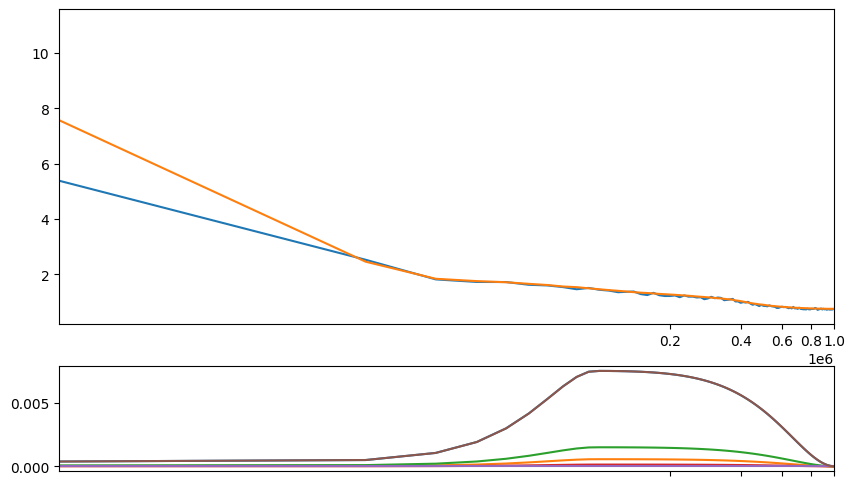

In [ ]:
# make sure it works at all, deocder cps
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('t2s-dim64-6454/*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0/2, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
model.save_model('t2s-chr-base-base.en-2d-512c-dim64-deccps-mixed6454.model')

samples,train,val,time
50048,1.57490,1.65323,03:08
100032,1.30007,1.41616,06:16
150016,1.27452,1.29610,09:24
200000,1.21859,1.23891,12:32
250048,1.13482,1.20451,15:40
300032,1.12068,1.18082,18:48
350016,1.09567,1.16008,21:55
400000,1.11592,1.11699,25:03
450048,1.02158,1.06097,28:11
500032,0.96963,1.01791,31:20


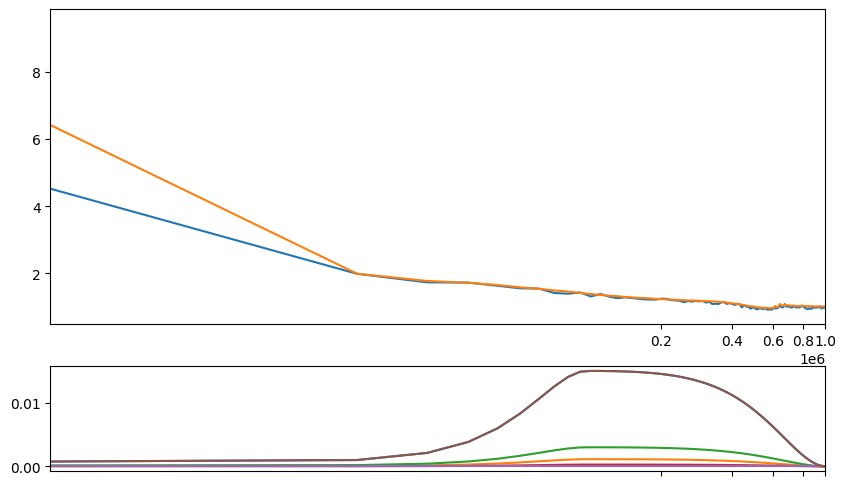

In [ ]:
# make sure it works at all, deocder cps
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('t2s-dim64-6454/*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
model.save_model('t2s-chr-base-base.en-2d-512c-dim64-deccps-mixed6454-2.model')

samples,train,val,time
50048,1.69897,1.60454,03:08
100032,1.48860,1.41279,06:15
150016,1.29894,1.29969,09:23
200000,1.18683,1.20707,12:31
250048,1.00874,1.06997,15:39
300032,0.96573,0.97376,18:47
350016,0.93865,0.93088,21:55
400000,0.84999,0.90498,25:02
450048,0.87169,0.89323,28:10
500032,0.88411,0.87570,31:19


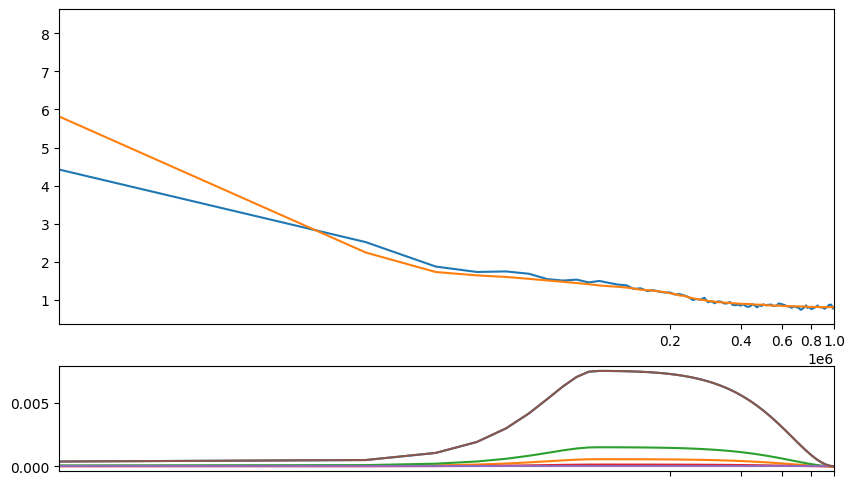

In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*.tar.gz', 250000, vq_codes=vqmodel.vq_codes+1)
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5)).cuda()
model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0/2, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
model.save_model('t2s-chr-base-base.en-2d-512c-dim64-6454.model')

samples,train,val,time
50048,1.42096,1.76318,01:32
100032,1.27539,1.56825,03:05
150016,1.18232,1.37608,04:38
200000,1.02870,1.29385,06:10
250048,0.76373,1.06234,07:43
300032,0.80656,0.96563,09:16
350016,0.81366,0.92360,10:49
400000,0.71119,0.89729,12:22
450048,0.68225,0.86979,13:55
500032,0.69954,0.85986,15:28


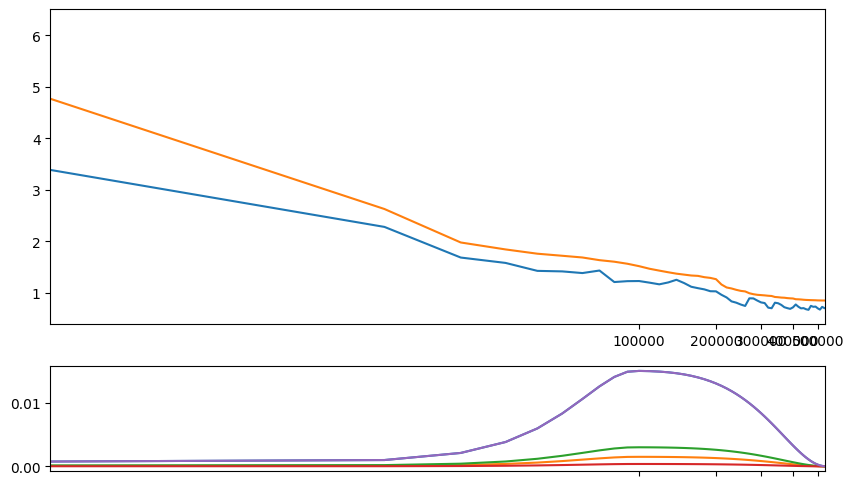

In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*.tar.gz', 67000, vq_codes=vqmodel.vq_codes+1)
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=vqmodel.codebook_dim, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5)).cuda()
# model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

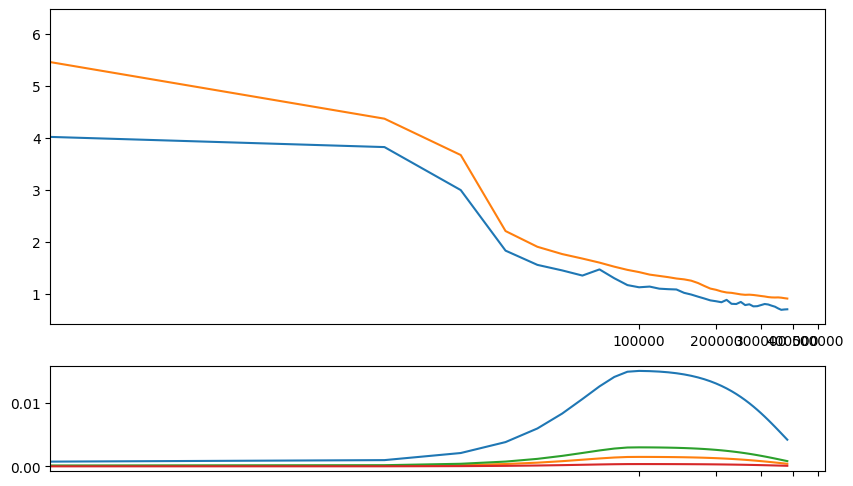

samples,train,val,time
50048,1.40568,1.90047,01:33
100032,1.11408,1.45658,03:06
150016,1.02597,1.29036,04:39
200000,0.84436,1.09712,06:11
250048,0.81835,0.99984,07:44
300032,0.74737,0.96436,09:16
350016,0.72640,0.92548,10:50


In [ ]:
# make sure it works at all
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-256c-dim64-4e-hyptuned-32gpu.model').cuda()
train_ds, val_ds = load_datasets('whisperspeech-t2s-512c-dim64/*.tar.gz', 67000, vq_codes=vqmodel.vq_codes+1)
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5)).cuda()
# model.load_frozen_semantic_embeddings(vqmodel)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.78801,2.96649,00:38
100032,2.17206,2.31484,01:16
150016,1.72292,1.83490,01:54
200000,1.61193,1.71674,02:33
250048,1.56491,1.66836,03:11
300032,1.52783,1.63776,03:49
350016,1.50633,1.61980,04:27
400000,1.50440,1.59825,05:05
450048,1.49942,1.58279,05:43
500032,1.46938,1.56660,06:21


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


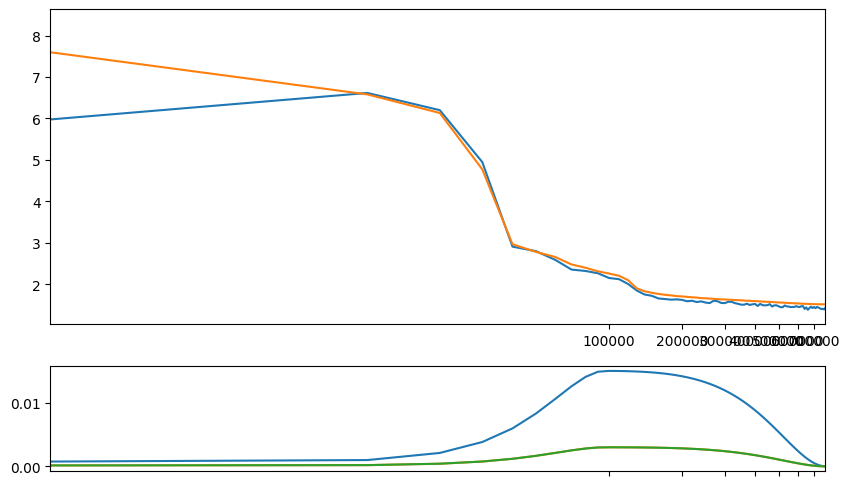

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('txts-large-6454.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('micro', dataset=train_ds, ttoks_codes=256, tunables=Tunables(encoder_depth_ratio=0.75)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
50048,2.77018,3.21193,00:39
100032,2.19978,2.33585,01:19
150016,1.72773,1.81870,01:58
200000,1.61463,1.72023,02:38
250048,1.58084,1.67646,03:17
300032,1.53818,1.64994,03:57
350016,1.52391,1.62680,04:36
400000,1.49011,1.60559,05:16
450048,1.50526,1.58791,05:55
500032,1.48537,1.57416,06:34


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


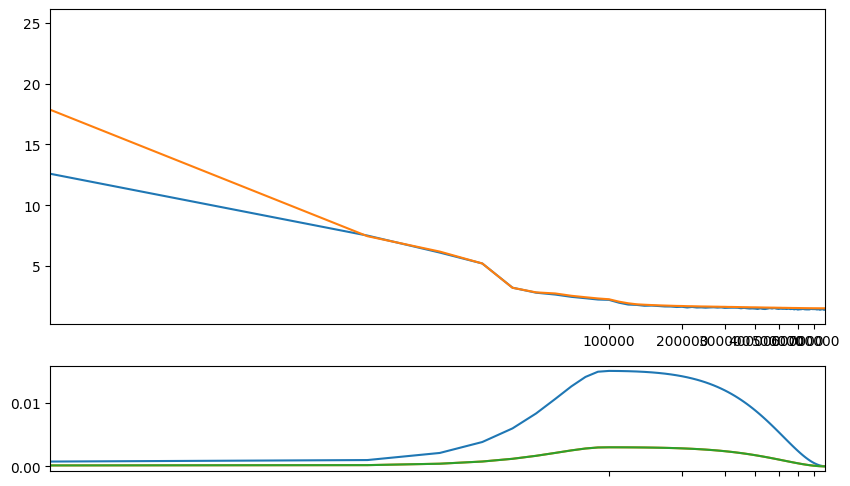

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('txts-large-6454.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('micro', dataset=train_ds, ttoks_codes=256, tunables=Tunables(encoder_depth_ratio=0.75)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)
# model.save_model('t2s-chr-micro-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454.model')

samples,train,val,time
25024,2.60773,3.69719,00:50
50048,2.17093,2.28062,01:40
75008,1.84834,1.99388,02:31
100032,1.69955,1.83580,03:21
125056,1.58153,1.71103,04:12
150016,1.52247,1.63647,05:02
175040,1.46376,1.56754,05:52
195136,1.42067,1.54652,06:33


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


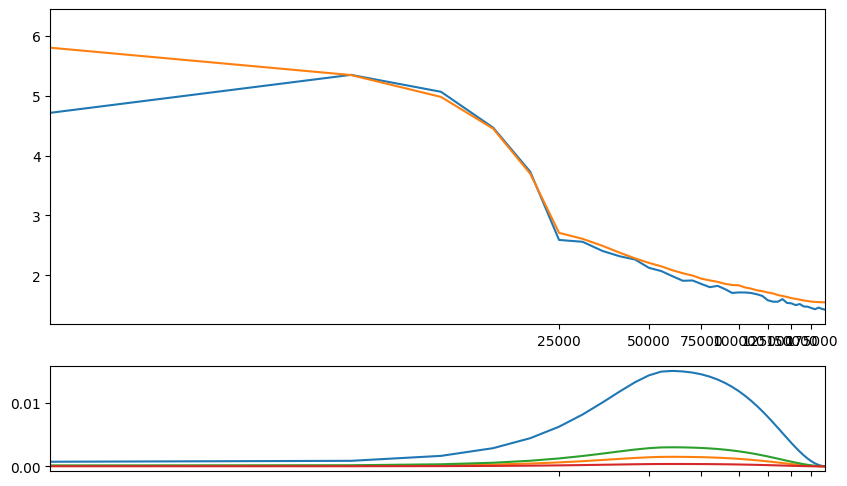

In [ ]:
# make sure it works at all
train_ds, val_ds = load_datasets('txts-large-6454.feather', 'stoks-2d-512c-cosine-padfix-premlp-learnpos-5e.feather')
model = make_model('tiny', dataset=train_ds).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=64, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=25000, run_valid_every_iters=5000)

In [ ]:
vqmodel = RQBottleneckTransformer.load_model(local_filename='vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.model').cuda()

samples,train,val,time
100000,2.00655,2.57978,03:57
187296,1.56021,1.91384,07:24


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


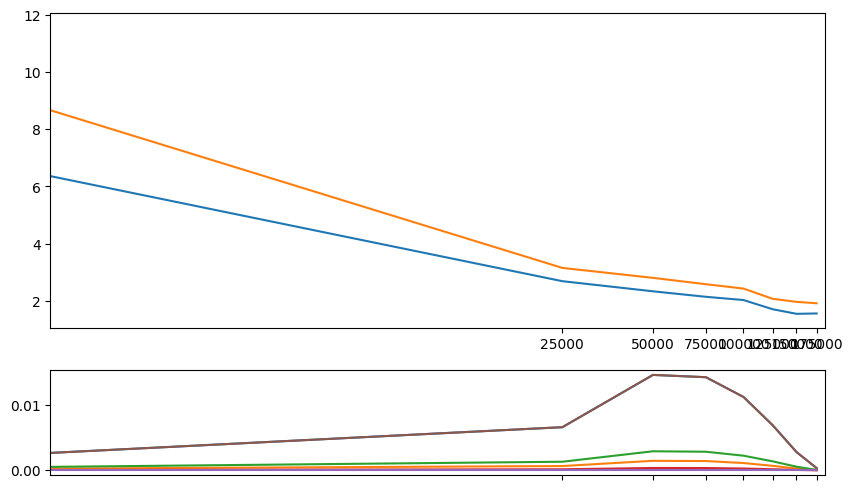

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-eot0.1x.model')

samples,train,val,time
100000,2.05328,2.59797,03:58
187296,1.68969,2.10436,07:26


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


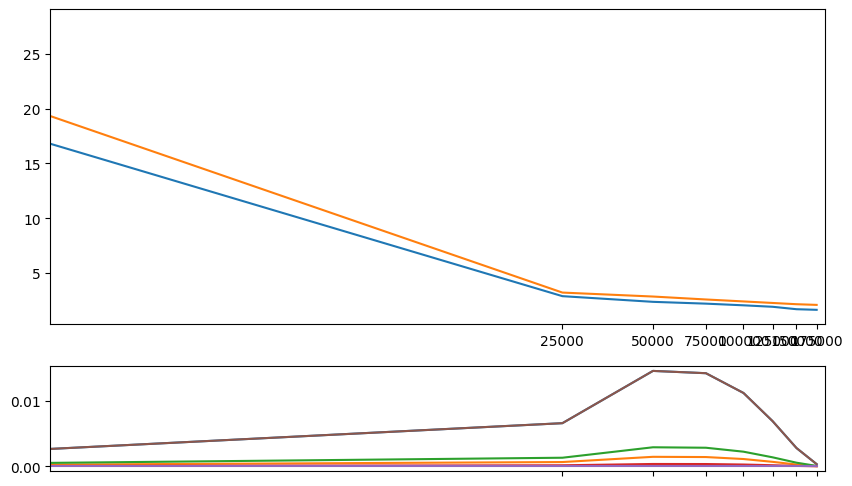

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-eot10x.model')

samples,train,val,time
100000,1.98257,2.55949,03:58
187296,1.69418,2.06103,07:26


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


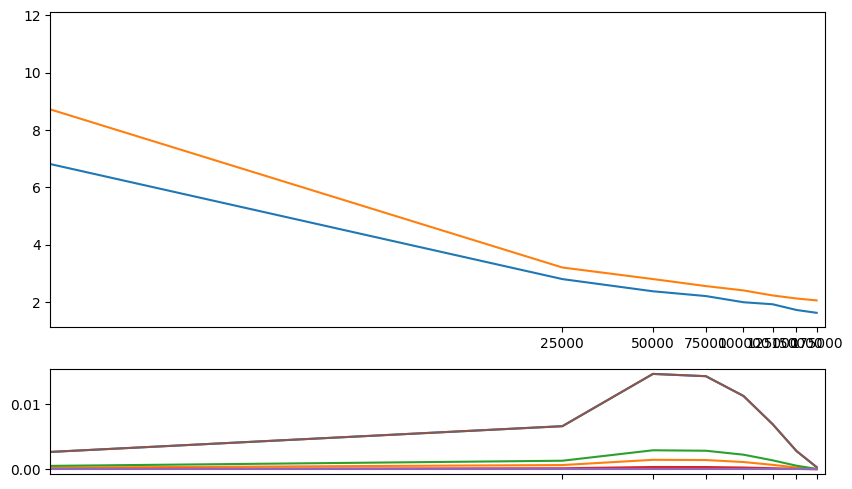

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-dropeot.model')

samples,train,val,time
100000,2.05267,3.04738,03:57
187296,1.73854,2.19192,07:25


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


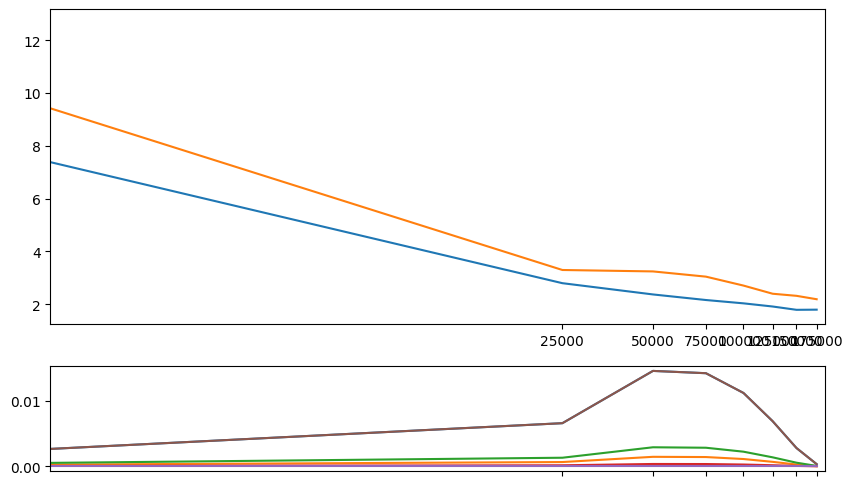

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-dropeot1.model')

samples,train,val,time
100000,2.16998,3.32899,03:58
200000,1.61419,2.16362,07:56
300000,1.46889,1.88969,11:55
400000,1.43118,1.82983,15:54
500000,1.38416,1.74227,19:52
561888,1.31517,1.72425,22:20


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


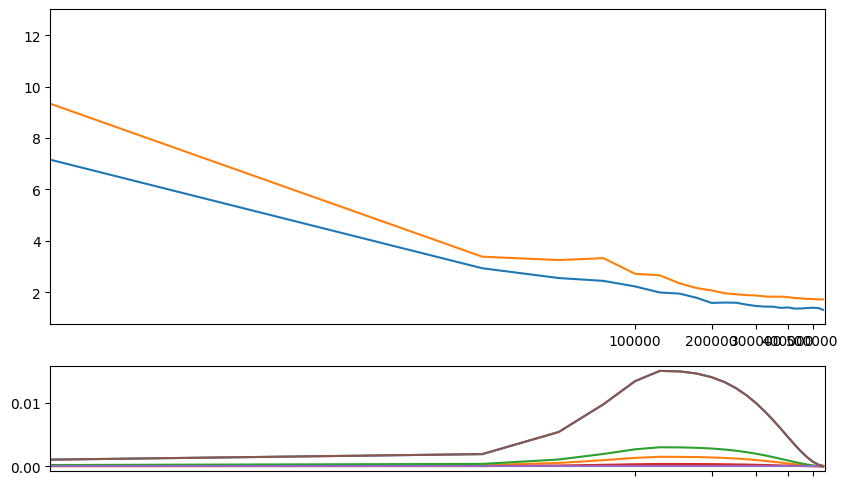

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=3,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-dropeot1-3e.model')

samples,train,val,time
100000,2.15739,3.14531,07:10
200000,1.61380,2.14494,14:20
300000,1.44079,1.92889,21:29
400000,1.39237,1.84527,28:40
500000,1.31629,1.86375,35:50
600000,1.30173,1.73855,43:00
700000,1.32894,1.71813,50:10
800000,1.21819,1.68263,57:21
900000,1.22189,1.66920,1:04:31
936480,1.22943,1.66867,1:07:09


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



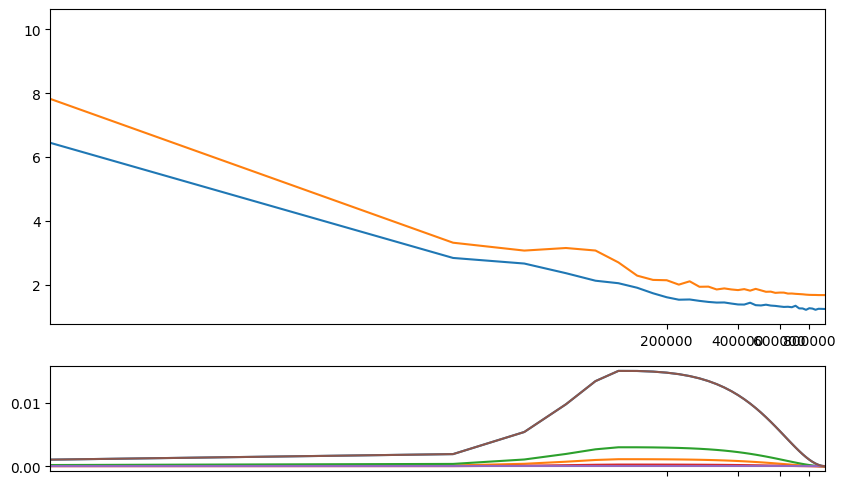

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=5,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-base-dropeot1-5e.model')

samples,train,val,time
100000,2.17942,2.77374,07:09
200000,1.79937,2.20654,14:19
300000,1.55872,1.98851,21:29
400000,1.48880,1.85471,28:39
500000,1.35137,1.78626,35:49
600000,1.35452,1.73572,43:00
700000,1.28091,1.70269,50:11
800000,1.21449,1.68077,57:23
900000,1.27294,1.66469,1:04:33
936480,1.23449,1.66274,1:07:12


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


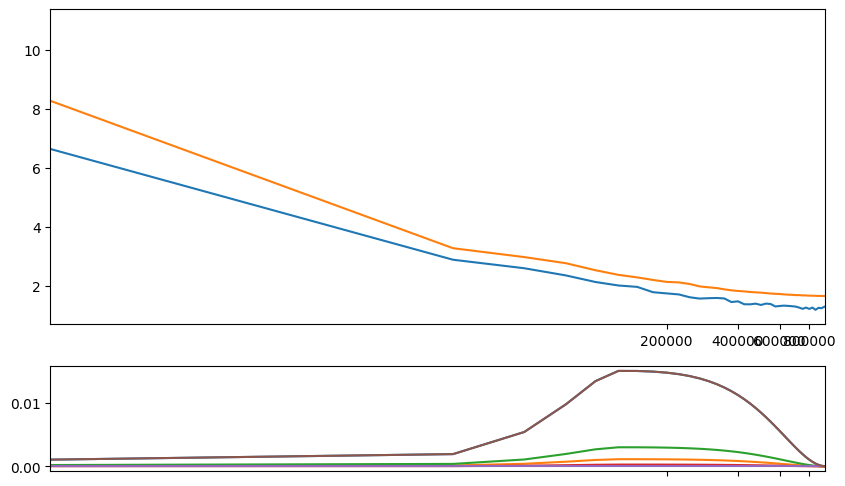

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(eot_dropout_p=.5)).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=5,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-base-dropeot_p.5-5e.model')

samples,train,val,time
100000,2.17033,2.89845,07:10
200000,1.50829,2.02612,14:20
300000,1.43682,1.84901,21:30
400000,1.35099,1.87154,28:40
500000,1.39165,1.76240,35:50
600000,1.31132,1.79887,43:00
700000,1.33037,1.74390,50:11
800000,1.27363,1.81697,57:22
900000,1.29424,1.71701,1:04:32
1000000,1.22769,1.72730,1:11:41


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


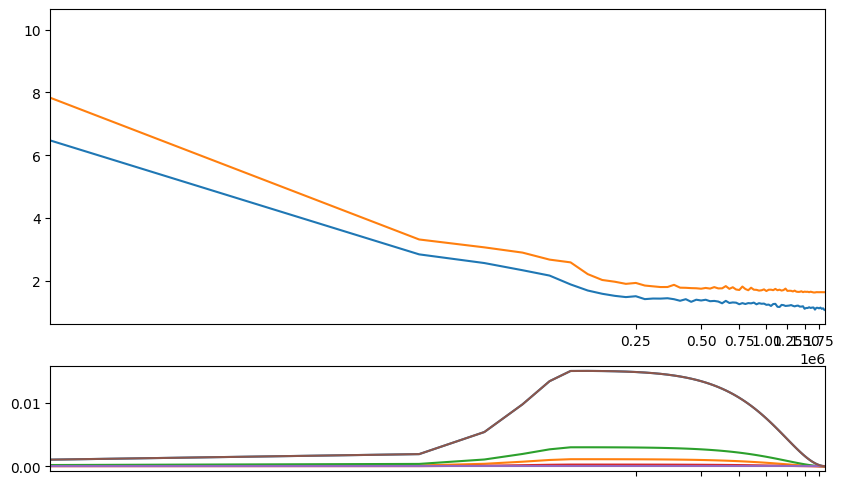

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=10,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-base-dropeot1-10e.model')

samples,train,val,time
100000,2.12544,2.91373,07:10
200000,1.66652,2.18800,14:20
300000,1.49255,1.94797,21:30
400000,1.49216,2.17191,28:40
500000,1.42051,2.13272,35:51
600000,1.43777,2.19251,43:01
700000,1.39764,1.91985,50:12
800000,1.38636,1.88027,57:24
900000,1.36741,1.77583,1:04:34
1000000,1.34063,1.78621,1:11:44


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IO

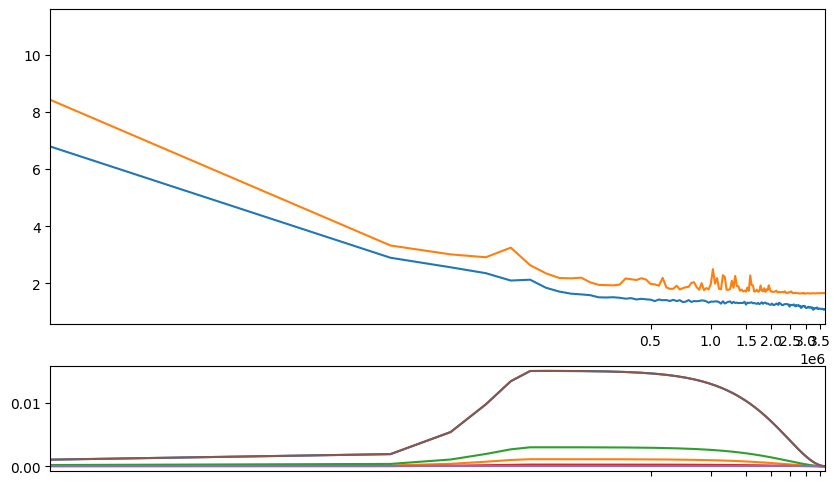

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=20,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-base-dropeot1-20e.model')

samples,train,val,time
100000,1.79375,2.43253,03:57
187296,1.50454,1.88259,07:25


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


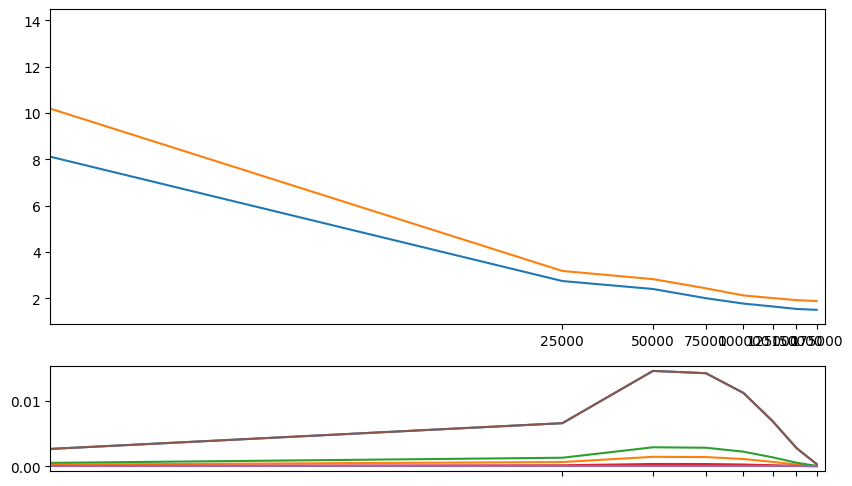

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-nodropeot.model')

In [ ]:
vqmodel = RQBottleneckTransformer.load_model(local_filename='vq-base.en-2d-4096c-cosine32-padfix-premlp-preconv-learnpos-5e-cleaned.model')

In [ ]:
vqmodel.rq.layers[0]._codebook.embed.shape

torch.Size([1, 4097, 32])

samples,train,val,time
100000,3.74254,3.83815,03:57
194048,3.29812,3.46448,07:39


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


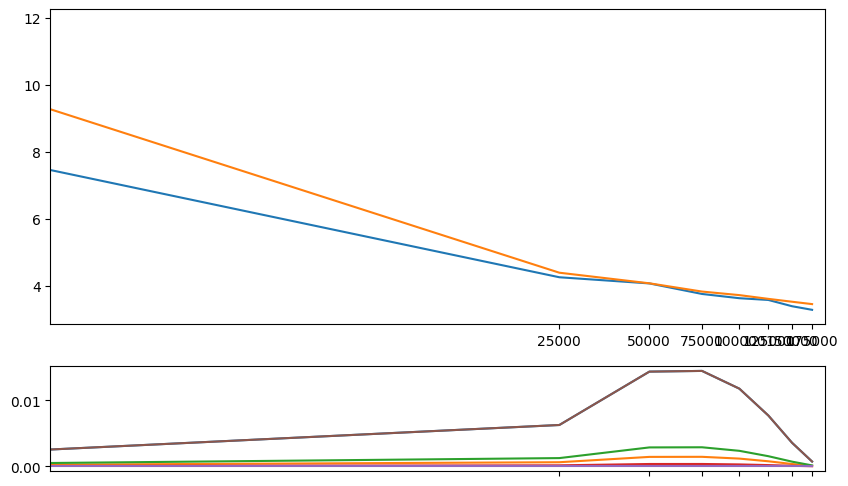

In [ ]:
# cleaned data
vqmodel = RQBottleneckTransformer.load_model(local_filename='vq-base.en-2d-4096c-cosine32-padfix-premlp-preconv-learnpos-5e-cleaned.model')
train_ds, val_ds = load_datasets('txts-large-6454.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-preconv-learnpos-5e-cleaned.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(eot_dropout_p=0)).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-cleaned.model')

samples,train,val,time
100000,3.68559,4.04428,07:10
200000,3.01551,3.21883,14:22
300000,3.24499,3.11739,21:33
400000,2.96113,3.07379,28:43
500000,2.97186,3.04313,35:54
600000,2.97368,3.01292,43:06
700000,2.78741,2.99100,50:17
800000,2.62833,2.96299,57:29
900000,2.91650,2.94995,1:04:40
970240,2.87281,2.94701,1:09:42


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


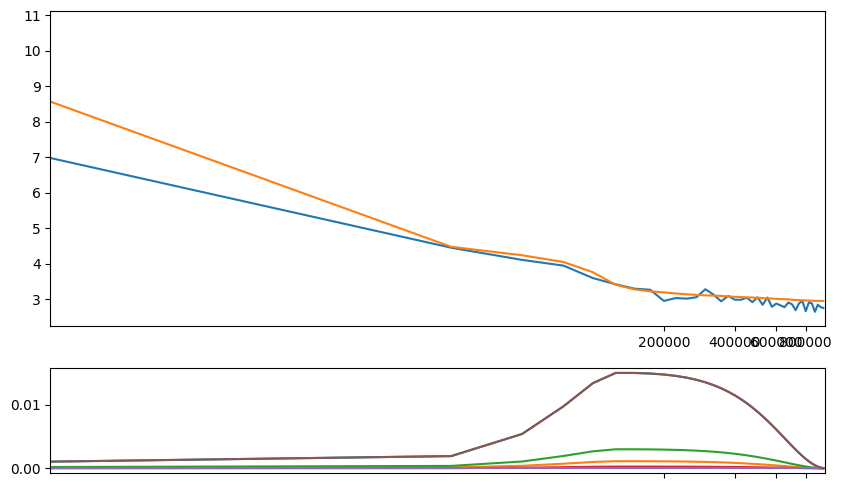

In [ ]:
# cleaned data
vqmodel = RQBottleneckTransformer.load_model(local_filename='vq-base.en-2d-4096c-cosine32-padfix-premlp-preconv-learnpos-5e-cleaned.model')
train_ds, val_ds = load_datasets('txts-large-6454.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-preconv-learnpos-5e-cleaned.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(eot_dropout_p=0)).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=5,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-base-cleaned.model')

samples,train,val,time
100000,2.06768,2.32964,03:58
194048,1.70456,1.86111,07:41


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


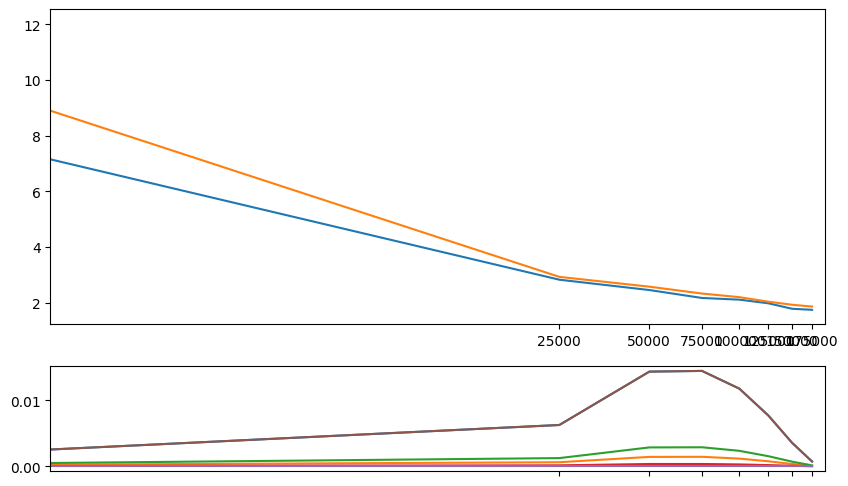

In [ ]:
# cleaned data
vqmodel = RQBottleneckTransformer.load_model(local_filename='vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')
train_ds, val_ds = load_datasets('txts-large-6454.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-cleaned.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(eot_dropout_p=0)).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-nopreconv-cleaned.model')

samples,train,val,time
100000,2.11192,2.53749,07:11
200000,1.55551,1.72807,14:22
300000,1.45162,1.62413,21:32
400000,1.41284,1.56698,28:44
500000,1.37127,1.52728,35:56
600000,1.31131,1.48980,43:08
700000,1.32659,1.46523,50:19
800000,1.23844,1.43754,57:31
900000,1.21430,1.42486,1:04:42
970240,1.21257,1.42089,1:09:45


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


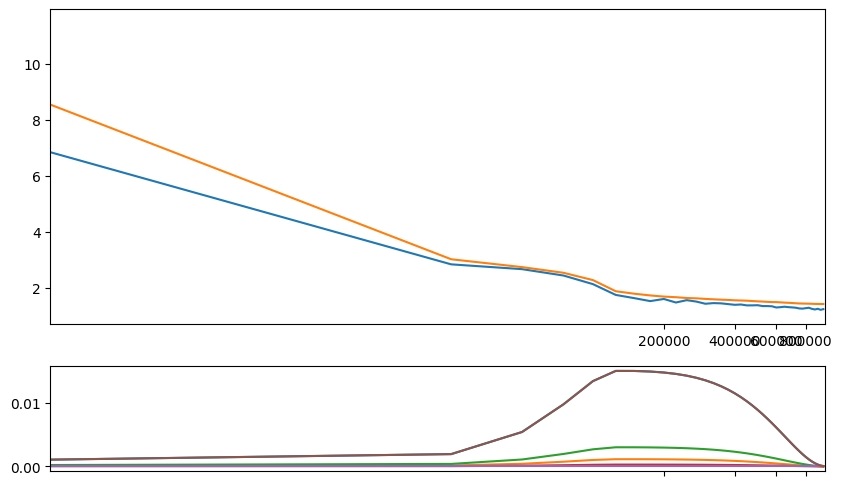

In [ ]:
# cleaned data
vqmodel = RQBottleneckTransformer.load_model(local_filename='vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')
train_ds, val_ds = load_datasets('txts-large-6454.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-cleaned.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(eot_dropout_p=0)).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=5,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-base-nopreconv-cleaned.model')

samples,train,val,time
100000,1.39675,1.01765,07:08
200000,0.99473,0.70335,14:15
300000,0.98095,0.65620,21:23
400000,0.91941,0.63601,28:31
500000,0.89299,0.62238,35:38
600000,0.91047,0.61567,42:45
700000,0.84376,0.60385,49:54
800000,0.83167,0.59419,57:02
900000,0.85216,0.58662,1:04:11
1000000,0.80380,0.57944,1:11:20


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



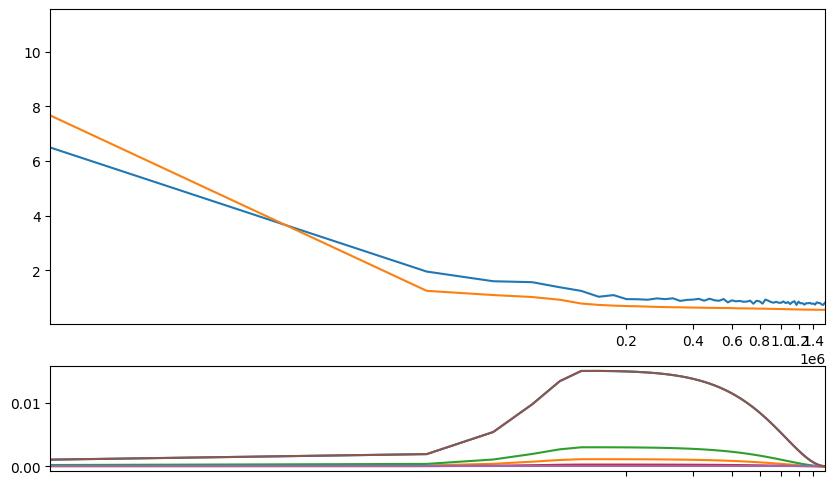

In [ ]:
# cleaned data
vq_name = "base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned"
vqmodel = RQBottleneckTransformer.load_model(local_filename=f'vq-{vq_name}.model')
train_ds, val_ds = load_datasets('txts-large-6454-eqvad.feather', f'stoks-{vq_name}.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(eot_dropout_p=0)).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=5,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-base-premean-cleaned-eqvad.model')

samples,train,val,time
26976,2.87742,2.94360,01:05


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


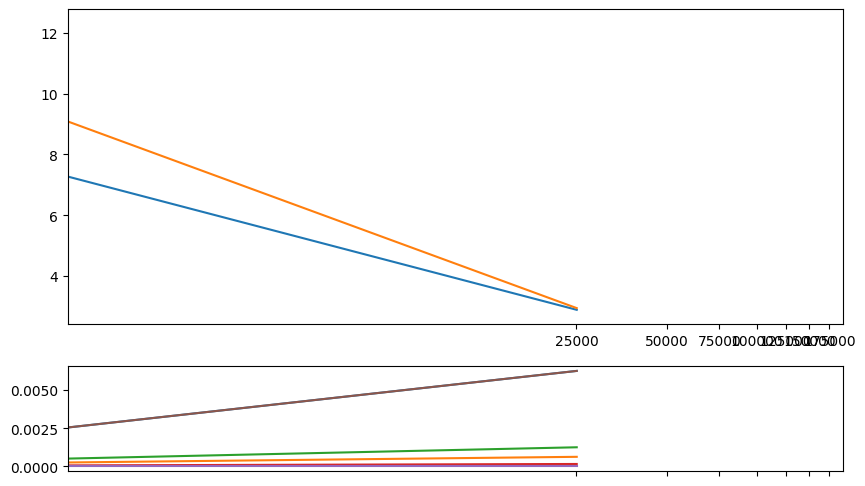

In [ ]:
# cleaned data
vqmodel = RQBottleneckTransformer.load_model(local_filename='vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.model')
train_ds, val_ds = load_datasets('txts-large-6454.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('tiny', dataset=train_ds, ttoks_codes=256, stoks_width=32, tunables=Tunables(eot_dropout_p=0)).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-tiny-nocleanvq.model')

samples,train,val,time
100000,2.05248,2.78820,07:10
200000,1.52021,1.95092,14:20
300000,1.45599,1.82633,21:30
400000,1.39701,1.77782,28:40
500000,1.33500,1.72368,35:49
600000,1.33470,1.69579,43:00
700000,1.26856,1.66998,50:11
800000,1.23700,1.64218,57:22
900000,1.24926,1.62649,1:04:33
936480,1.19744,1.62555,1:07:10


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



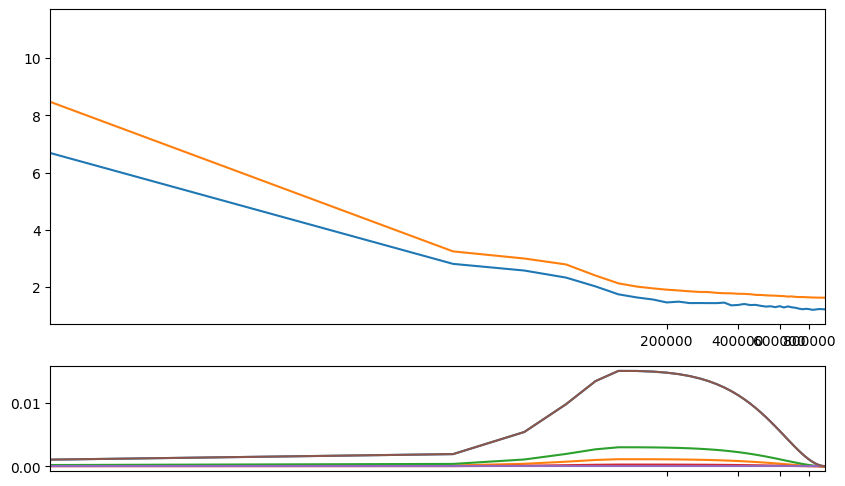

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=5,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-chr-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454-cleaned.model')

samples,train,val,time
100000,2.18693,2.79553,07:09
200000,1.72759,2.21211,14:17
300000,1.58026,2.02650,21:25
400000,1.50245,1.91226,28:32
500000,1.46347,1.84637,35:40
600000,1.41378,1.78844,42:49
700000,1.36574,1.75137,49:59
800000,1.32156,1.73190,57:07
900000,1.30705,1.71549,1:04:16
936480,1.25838,1.71270,1:06:52


/root/workspace/spear-tts-pytorch/whisperspeech/train.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/root/workspace/spear-tts-pytorch/whisperspeech/train.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(500, self.total_steps)


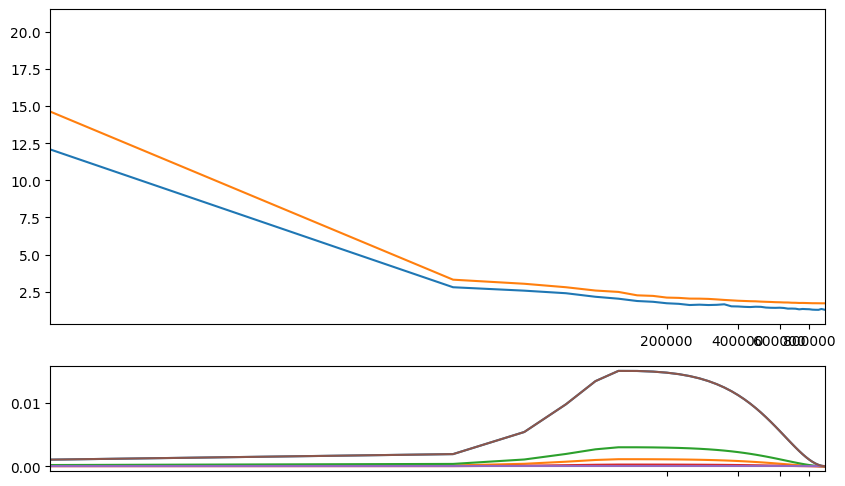

In [ ]:
# reuse the VQ stoks padding token
train_ds, val_ds = load_datasets('txts-large-6454-cleaned.feather', 'stoks-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.feather')
model = make_model('base', dataset=train_ds, ttoks_codes=256, stoks_width=32).cuda()
with torch.no_grad(): model.decoder.embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
model.decoder.embedding.lr_scale = 0
for m in [model.decoder.emb_to_hidden, model.decoder.hidden_to_emb]:
    m.lr_scale = 5
    std = model.tunables.init_std
    torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=5,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=25000)
model.save_model('t2s-chr-eot10x-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-large-6454-cleaned.model')

## Optimize the sampling parameters

Few things to keep in mind:

- decoding with quantized Whisper is not the ultimate goal (and quantized Whisper itself has an average WER of > 6%)
- the dots on the plots don't show perfect samples (WER=0%) because of logscale, the green line average line does

In [ ]:
vqmodel = vq_stoks.RQBottleneckTransformer.load_model(local_filename='vqmodel-512c-dim64-4e-hyptuned-32gpu.model').cuda()
t2s = TSARTransformer.load_model(local_filename='t2s-chr-base-base.en-2d-512c-dim64-deccps.model').cuda()

In [ ]:
def search_infer_hyp(T_range=(.1,10), top_k_range=(1,128)):
    stats = WERStats()
    for snd, gt_text in progress_bar(librispeech_data('/data/LibriSpeech/test-clean'), total=1000):
        T = 10**rand(*np.log10(T_range))
        top_k = round(10**rand(*np.log10([top_k_range[0]-.5,top_k_range[1]+.5])))
        stoks = t2s.generate(gt_text.lower(), show_progress_bar=False, top_k=top_k, T=T)
        text = vqmodel.decode_text(stoks)[0].text
        stats.push_sample(snd, gt_text, text)
        stats.push(top_k = top_k, T = T)
    stats = stats.df().sort_values('wer')
    ax = stats.plot.scatter('top_k', 'wer', logx=True, logy=True, alpha=.5)
    ax.plot(stats.groupby('top_k')['wer'].mean(), c='green', alpha=.3)
    stats.plot.scatter('T', 'wer', logx=True, logy=True, alpha=.5)
    return stats

,secs,idx,gt_text,text,wer,mer,wil,wip,top_k,T
315,8.510,None,NO ONE SAW HIM DO THIS FOR ALL WERE LOOKING AT...,"No one saw him do this, for all were looking a...",0.000000,0.000000,0.000000,1.000000,1,0.108978
445,5.645,None,FINALLY THE ONE PARTY WENT OFF EXULTING AND TH...,"Finally the one party went off exulting, and t...",0.000000,0.000000,0.000000,1.000000,15,0.504203
451,2.665,None,SHE FOUND THE DOOR BUT IT WAS LOCKED OUTSIDE,She found the door but it was locked outside.,0.000000,0.000000,0.000000,1.000000,6,3.195216
127,6.270,None,THE GOLDEN STAR OF TINSEL WAS STILL ON THE TOP...,The golden star of tinsel was still on the top...,0.000000,0.000000,0.000000,1.000000,95,0.233646
711,2.690,None,BY REASON AND AFFECTION,by reason and affection.,0.000000,0.000000,0.000000,1.000000,2,0.599798
...,...,...,...,...,...,...,...,...,...,...
482,7.605,None,HE PASSED THROUGH HENLEY SAINT ALBANS AND CAME...,He's a successful cook and he's not going to b...,9.647059,0.987952,0.998583,0.001417,63,6.728842
387,2.735,None,A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL,"I am right, right, right, right, right, right,...",14.125000,1.000000,1.000000,0.000000,49,9.033729
89,4.000,None,CRIED THE YOUNG LADIES AND THEY QUICKLY PUT OU...,"Grandma, you're a real man. You're a significa...",14.545455,1.000000,1.000000,0.000000,51,5.997146
598,2.900,None,EACH OF US IS LASHED TO SOME PART OF THE RAFT,He's not going to die on gas. He's not going t...,14.636364,0.987730,0.997769,0.002231,113,7.302803


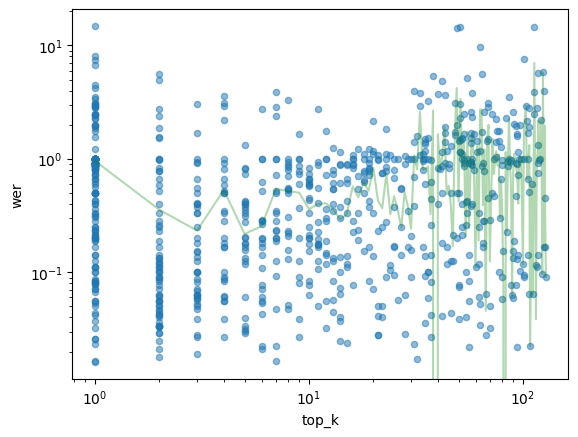

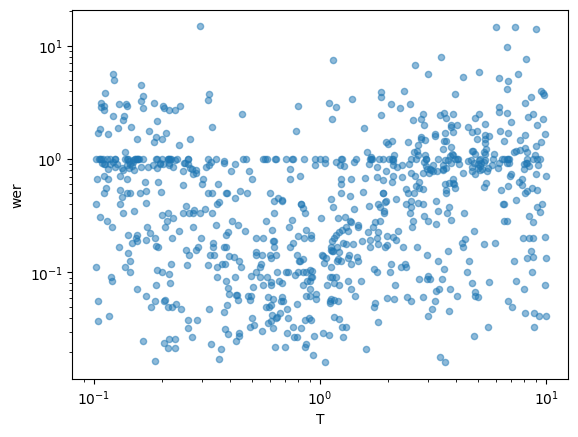

In [ ]:
search_infer_hyp()

,secs,idx,gt_text,text,wer,mer,wil,wip,top_k,T
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said while on her lap,...",0.000000,0.000000,0.000000,1.000000,49,0.933901
268,2.825,None,SHE'S GOING TO PUT THE IRONING THINGS AWAY,She's going to put the ironing things away.,0.000000,0.000000,0.000000,1.000000,3,0.848717
267,3.595,None,COLD IS IT MY DARLING BLESS YOUR SWEET FACE,Cold is it my darling bless your sweet face?,0.000000,0.000000,0.000000,1.000000,3,0.691180
620,4.730,None,THE SHADOW OF THE RAFT WAS CLEARLY OUTLINED UP...,The shadow of the raft was clearly outlined up...,0.000000,0.000000,0.000000,1.000000,8,0.729119
623,7.000,None,THESE THOUGHTS AGITATED ME ALL DAY AND MY IMAG...,"These thoughts agitated me all day, and my ima...",0.000000,0.000000,0.000000,1.000000,113,0.880830
...,...,...,...,...,...,...,...,...,...,...
393,5.980,None,I LEFT INSTRUCTIONS FOR SHIPPING MY CONTAINERS...,"And if you are not, you can see that the video...",7.625000,0.983871,0.997984,0.002016,1,0.519047
322,3.200,None,I NOW USE THEM AS ORNAMENTAL STATUARY IN MY GA...,"Now you know, I'm not going to be able to do t...",9.200000,0.989247,0.998925,0.001075,1,0.907901
676,4.280,None,THAT IS A VERY FINE CAP YOU HAVE HE SAID,"That is a very, very, very, very, very, very, ...",10.900000,0.964602,0.985841,0.014159,1,0.594969
592,1.805,None,HANS STIRS NOT,"hands, stirs, stirs, stirs, stirs, stirs, stir...",24.666667,0.986667,0.995556,0.004444,29,0.569005


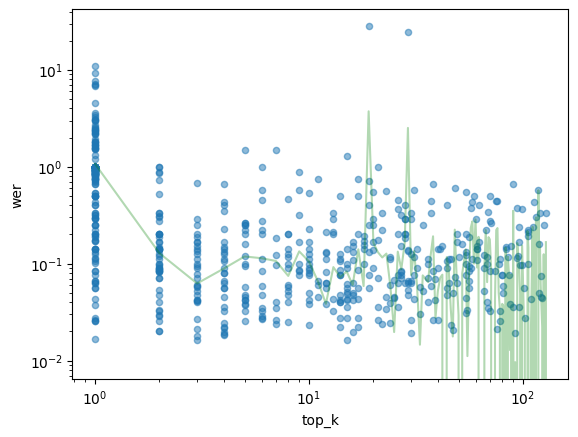

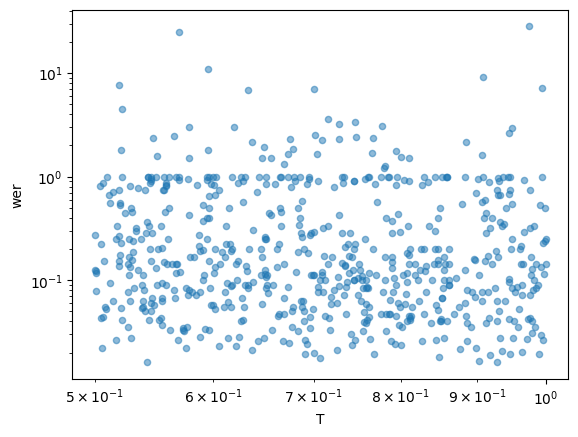

In [ ]:
stats = search_infer_hyp(T_range=(.5,1))

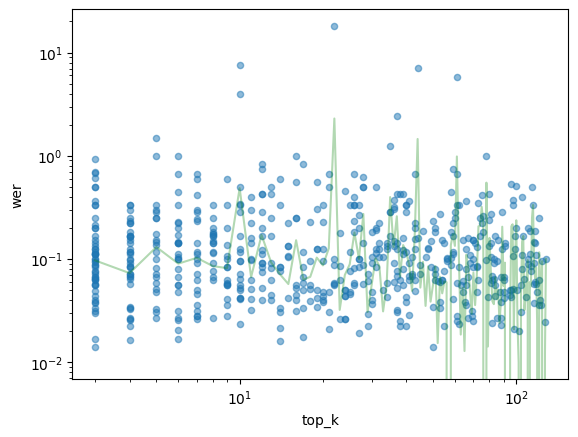

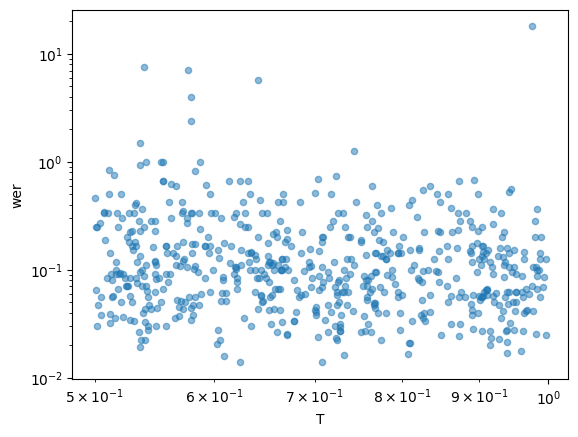

In [ ]:
stats = search_infer_hyp(T_range=(.5,1), top_k_range=(3,128))

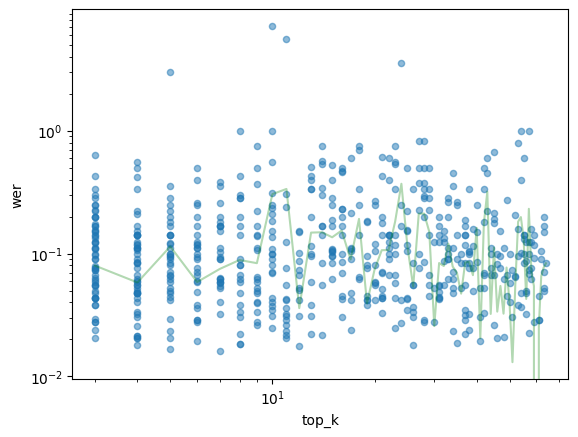

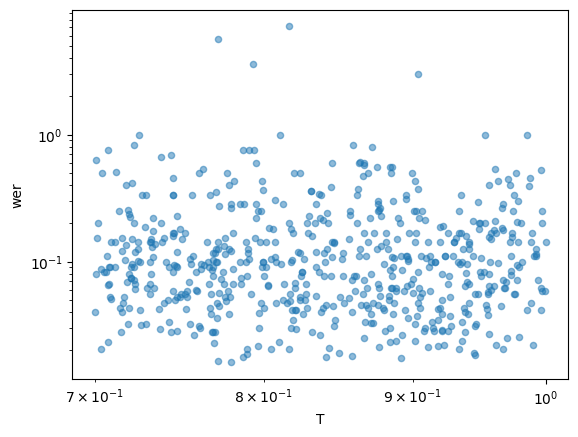

In [ ]:
stats = search_infer_hyp(T_range=(.7,1), top_k_range=(3,64))

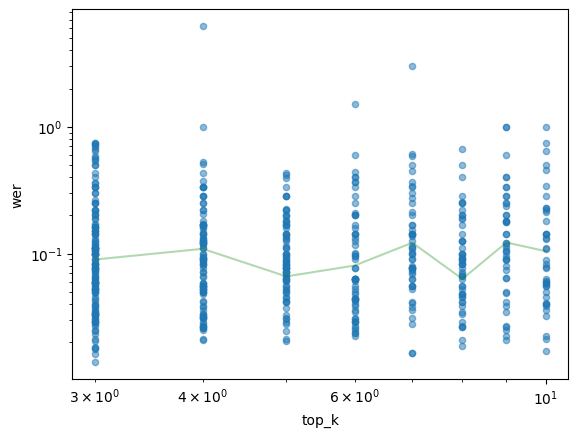

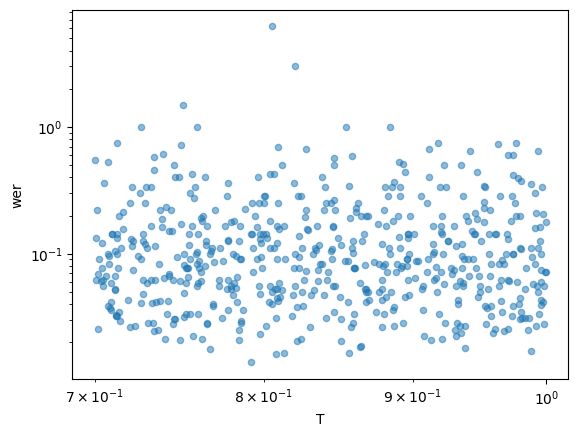

In [ ]:
stats = search_infer_hyp(T_range=(.7,1), top_k_range=(3,10))

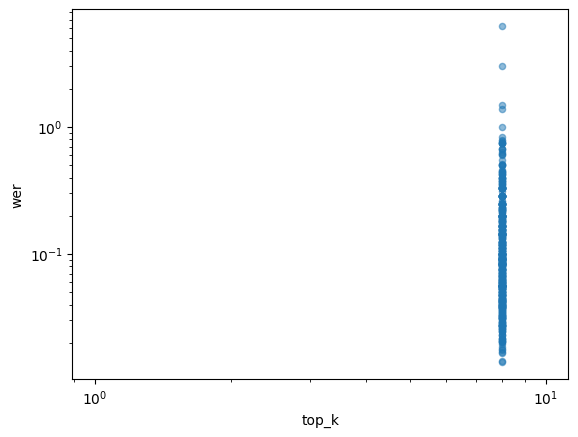

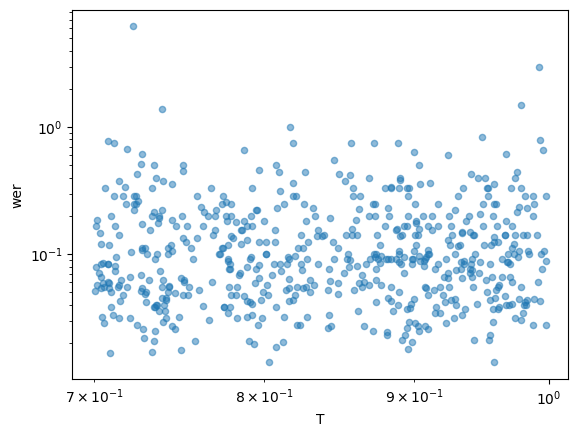

In [ ]:
stats = search_infer_hyp(T_range=(.7,1), top_k_range=(8,8))

<Axes: xlabel='secs', ylabel='wer'>

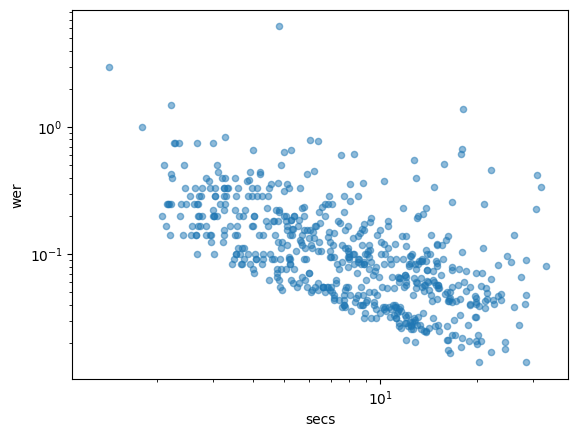

In [ ]:
stats.plot.scatter('secs', 'wer', logx=True, logy=True, alpha=.5)